In [1]:
import sys
sys.path.append("../") # adding the path to read the utils file
from sklearnex import patch_sklearn
patch_sklearn(global_patch=True)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics, tree
from shap import TreeExplainer
import fasttreeshap
from shap import plots, Explanation
import graphviz 
from yellowbrick.model_selection import LearningCurve
import time
import shap
from utils import *
import pickle
import glob
from yellowbrick.classifier import ROCAUC
from yellowbrick.contrib.wrapper import wrap

pd.set_option('display.max_columns', None)

Scikit-learn was successfully globally patched by Intel(R) Extension for Scikit-learn


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
ds = pd.concat([pd.read_csv(csv_file, engine='pyarrow', index_col='id') for csv_file in glob.glob('../datasets/NFS-2023-nTE/*.csv')], ignore_index=True)
ds.head()

expiration_id         src_ip            src_mac   src_oui  src_port  \
0              1  192.168.10.50  00:19:b9:0a:69:f1  00:19:b9     33898   
1              1  192.168.10.50  00:19:b9:0a:69:f1  00:19:b9     33904   
2              0  192.168.10.14  b8:ac:6f:36:07:ee  b8:ac:6f     59555   
3              0  192.168.10.14  b8:ac:6f:36:07:ee  b8:ac:6f     59135   
4              0  192.168.10.50  00:19:b9:0a:69:f1  00:19:b9       123   

         dst_ip            dst_mac   dst_oui  dst_port  protocol  ip_version  \
0  192.168.10.3  18:66:da:9b:e3:7d  18:66:da       389         6           4   
1  192.168.10.3  18:66:da:9b:e3:7d  18:66:da       389         6           4   
2  192.168.10.3  18:66:da:9b:e3:7d  18:66:da        53        17           4   
3  65.55.44.109  00:c1:b1:14:eb:31  00:c1:b1       443         6           4   
4   129.6.15.29  00:c1:b1:14:eb:31  00:c1:b1       123        17           4   

   vlan_id  bidirectional_first_seen_ms  bidirectional_last_seen_ms  \
0        0                1499342340490               1499342453585   
1        0                1499342340491               1499342453964   
2        0                1499342357298               1499342357299   
3        0                1499342357299               1499342417611   
4        0                1499342395411               1499342395442   

   bidirectional_duration_ms  bidirectional_packets  bidirectional_bytes  \
0                     113095                     36                12216   
1                     113473                     54                15605   
2                          1                      2                  296   
3                      60312                     18                 7559   
4                         31                      2                  180   

   src2dst_first_seen_ms  src2dst_last_seen_ms  src2dst_duration_ms  \
0          1499342340490         1499342453585               113095   
1          1499342340491         1499342453964               113473   
2          1499342357298         1499342357298                    0   
3          1499342357299         1499342417611                60312   
4          1499342395411         1499342395411                    0   

   src2dst_packets  src2dst_bytes  dst2src_first_seen_ms  \
0               24           6418          1499342340490   
1               34           7926          1499342340491   
2                1             93          1499342357299   
3               10           2888          1499342357349   
4                1             90          1499342395442   

   dst2src_last_seen_ms  dst2src_duration_ms  dst2src_packets  dst2src_bytes  \
0         1499342453585               113095               12           5798   
1         1499342453918               113427               20           7679   
2         1499342357299                    0                1            203   
3         1499342417610                60261                8           4671   
4         1499342395442                    0                1             90   

   bidirectional_min_ps  bidirectional_mean_ps  bidirectional_stddev_ps  \
0                    66             339.333333               236.650194   
1                    66             288.981481               200.112750   
2                    93             148.000000                77.781746   
3                    60             419.944444               522.680700   
4                    90              90.000000                 0.000000   

   bidirectional_max_ps  src2dst_min_ps  src2dst_mean_ps  src2dst_stddev_ps  \
0                   989              66       267.416667         205.748880   
1                  1205              66       233.117647         173.216936   
2                   203              93        93.000000           0.000000   
3                  1514              60       288.800000         393.690177   
4                    90              90        90.000000           0.000000   

In [3]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111131 entries, 0 to 2111130
Data columns (total 76 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   expiration_id                 int64  
 1   src_ip                        object 
 2   src_mac                       object 
 3   src_oui                       object 
 4   src_port                      int64  
 5   dst_ip                        object 
 6   dst_mac                       object 
 7   dst_oui                       object 
 8   dst_port                      int64  
 9   protocol                      int64  
 10  ip_version                    int64  
 11  vlan_id                       int64  
 12  bidirectional_first_seen_ms   int64  
 13  bidirectional_last_seen_ms    int64  
 14  bidirectional_duration_ms     int64  
 15  bidirectional_packets         int64  
 16  bidirectional_bytes           int64  
 17  src2dst_first_seen_ms         int64  
 18  src2dst_last_seen_ms  

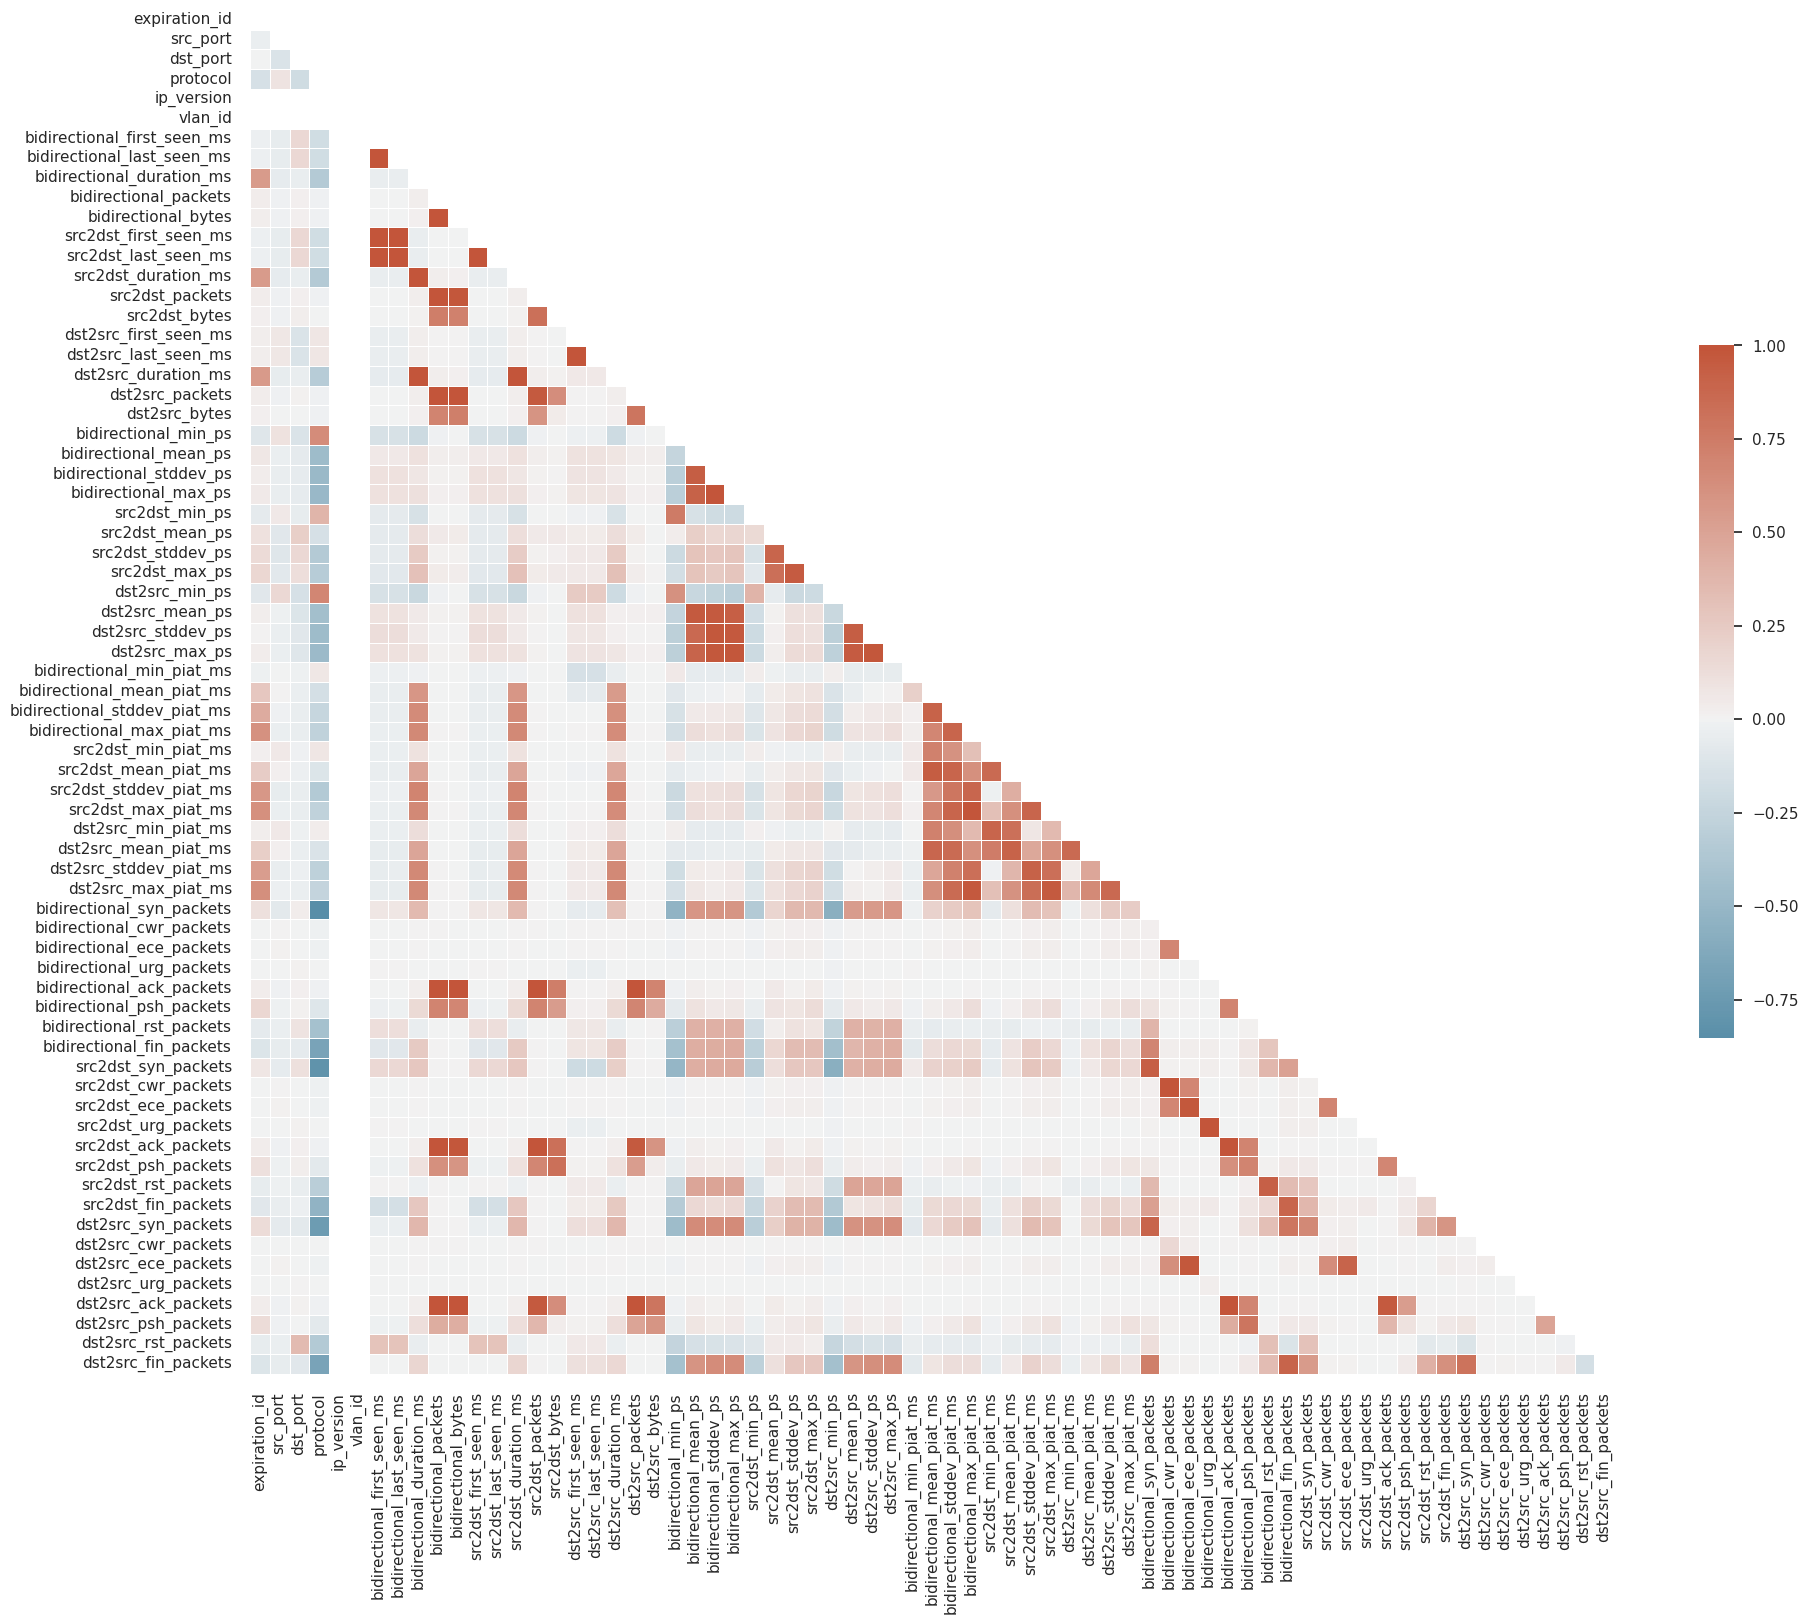

In [4]:
show_corr_matrix(ds)

In [5]:
compute_ratio(ds,'label')

                            Ratio
label                            
BENIGN                      76.37
PortScan                    10.61
DoS Hulk                     7.49
DDoS                         4.41
DoS GoldenEye                0.37
DoS slowloris                0.25
FTP-Patator                  0.19
SSH-Patator                  0.14
DoS Slowhttptest             0.13
Bot                          0.03
Web Attack - Brute Force     0.01
Web Attack - XSS             0.00
Infiltration                 0.00
Web Attack - Sql Injection   0.00
Heartbleed                   0.00


In [6]:
ds.label.value_counts()

label
BENIGN                        1612267
PortScan                       223886
DoS Hulk                       158027
DDoS                            93178
DoS GoldenEye                    7916
DoS slowloris                    5192
FTP-Patator                      3992
SSH-Patator                      2980
DoS Slowhttptest                 2727
Bot                               738
Web Attack - Brute Force          151
Web Attack - XSS                   27
Infiltration                       27
Web Attack - Sql Injection         12
Heartbleed                         11
Name: count, dtype: int64

In [7]:
ds = ds.drop(columns=['expiration_id','src_ip','src_mac','src_oui','src_port','dst_ip','dst_mac','dst_oui','dst_port','ip_version','vlan_id'])

In [8]:
sample_weights = ds.label.value_counts().to_dict()

In [9]:
sample_weights['BENIGN'] = 738
sample_weights['PortScan'] = 738
sample_weights['DoS Hulk'] = 738
sample_weights['DDoS'] = 738
sample_weights['FTP-Patator'] = 738
sample_weights['DoS GoldenEye'] = 738
sample_weights['DoS slowloris'] = 738
sample_weights['SSH-Patator'] = 738
sample_weights['DoS Slowhttptest'] = 738

In [10]:
params = {
    "n_jobs": -1, 
    "n_estimators": 20,
    "max_depth": 14,
    "random_state": 42,
    "max_features": ds.columns.size - 1,
}

rf = RandomForestClassifier(**params)

rus = RandomUnderSampler(random_state=42, sampling_strategy=sample_weights)
X_res, y_res = rus.fit_resample(ds.drop(columns=['label']), ds['label'])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.2, random_state=12, shuffle=True, stratify=y_res)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel

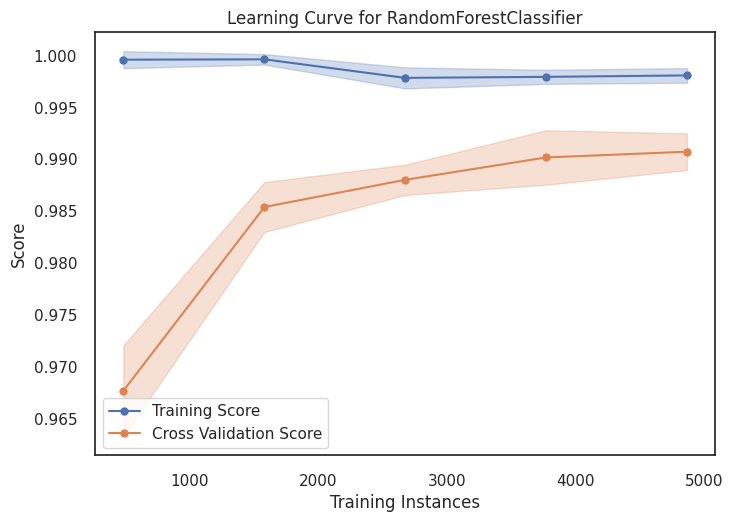

In [12]:
if True:
    cv = 5
    visualizer = LearningCurve(estimator=rf, cv=cv, scoring='f1_weighted', n_jobs=1, random_state=123)
    visualizer.fit(X_train, y_train)
    visualizer.show(outpath="rf_data/learning_curve.png")


![Alt text](rf_data/learning_curve.png)

In [13]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skf.get_n_splits(X_res, y_res)

5

In [14]:
avg_train_f1 = []
avg_test_f1 = []

for i, (train_index, test_index) in enumerate(skf.split(X_res, y_res)):
    print(f"Fold {i}:")
    rf.fit(X_res.iloc[train_index], y_res.iloc[train_index])
    y_predicted_train = rf.predict(X_res.iloc[train_index])
    y_predicted_test = rf.predict(X_res.iloc[test_index])
    train_f1 = metrics.f1_score(y_res.iloc[train_index], y_predicted_train, average='weighted')
    test_f1 = metrics.f1_score(y_res.iloc[test_index], y_predicted_test, average='weighted')
    print(f"Train F1: {train_f1:.4f}")
    print(f"Test F1: {test_f1:.4f}")
    avg_train_f1.append(train_f1)
    avg_test_f1.append(test_f1)

print(f"Average Train F1: {np.mean(avg_train_f1):.4f}")
print(f"Average Test F1: {np.mean(avg_test_f1):.4f}")

Fold 0:
Train F1: 0.9990
Test F1: 0.9953
Fold 1:


Train F1: 0.9988
Test F1: 0.9928
Fold 2:
Train F1: 0.9993
Test F1: 0.9868
Fold 3:
Train F1: 0.9992
Test F1: 0.9879
Fold 4:
Train F1: 0.9974
Test F1: 0.9914
Average Train F1: 0.9987
Average Test F1: 0.9908


In [15]:
%time rf.fit(X_train, y_train)

CPU times: user 578 ms, sys: 0 ns, total: 578 ms
Wall time: 128 ms


RandomForestClassifier(max_depth=14, max_features=64, n_estimators=20,
                       n_jobs=-1, random_state=42)

In [16]:
%time y_predicted_train = rf.predict(X_train)
%time y_predicted_test = rf.predict(X_test)

CPU times: user 33.7 ms, sys: 6.02 ms, total: 39.7 ms
Wall time: 12.9 ms
CPU times: user 15.3 ms, sys: 2.43 ms, total: 17.7 ms
Wall time: 9.55 ms


In [17]:
performanceMetricsDFWeighted(metrics, y_train, y_predicted_train, y_test, y_predicted_test, 'weighted')

Measure     Train      Test
0   ACCURACY  0.999343  0.991459
1  PRECISION  0.999344  0.992139
2     RECALL  0.999343  0.991459
3   F1 SCORE  0.999342  0.991074

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


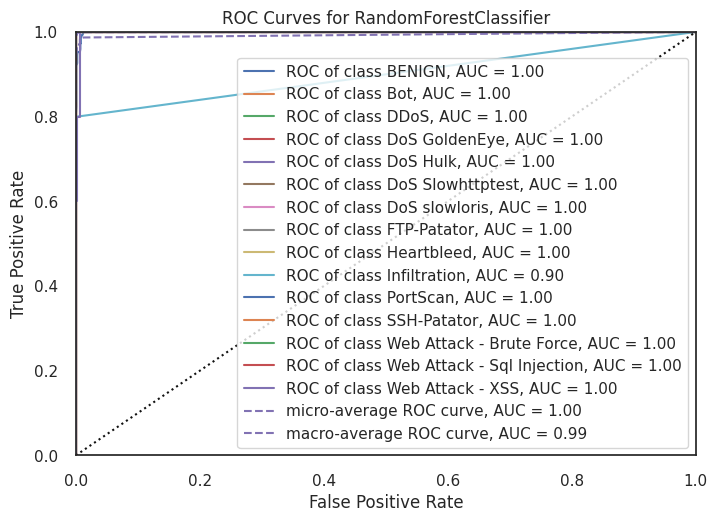

<Axes: title={'center': 'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [18]:
model = wrap(rf)
visualizer = ROCAUC(model)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

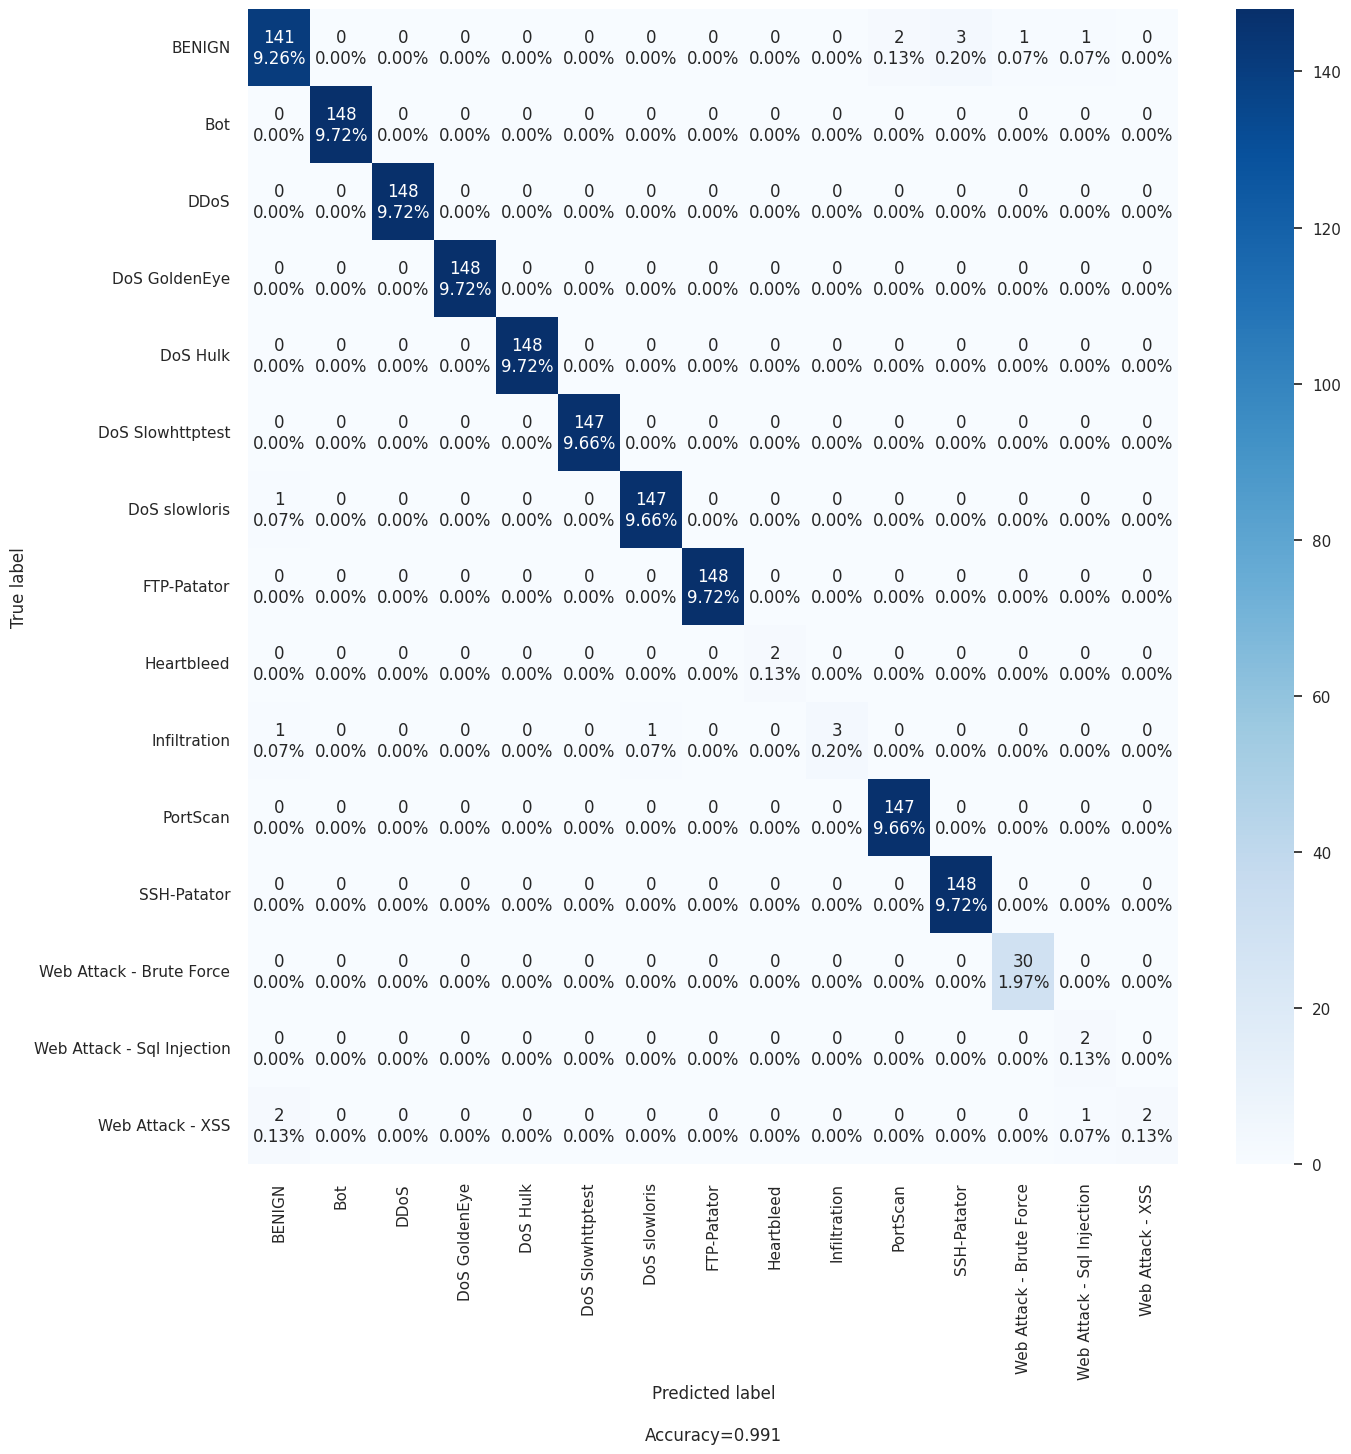

In [19]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(rf.classes_)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues',
                      figsize=(15,15))

In [20]:
for num, clf in enumerate(rf.estimators_):
    dot_data = tree.export_graphviz(clf, feature_names=X_res.columns, out_file=None, class_names=rf.classes_)
    graph = graphviz.Source(dot_data)
    graph.render('tree/tree_rf_' + str(num))

In [21]:
start_time = time.time()
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.022 seconds


Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


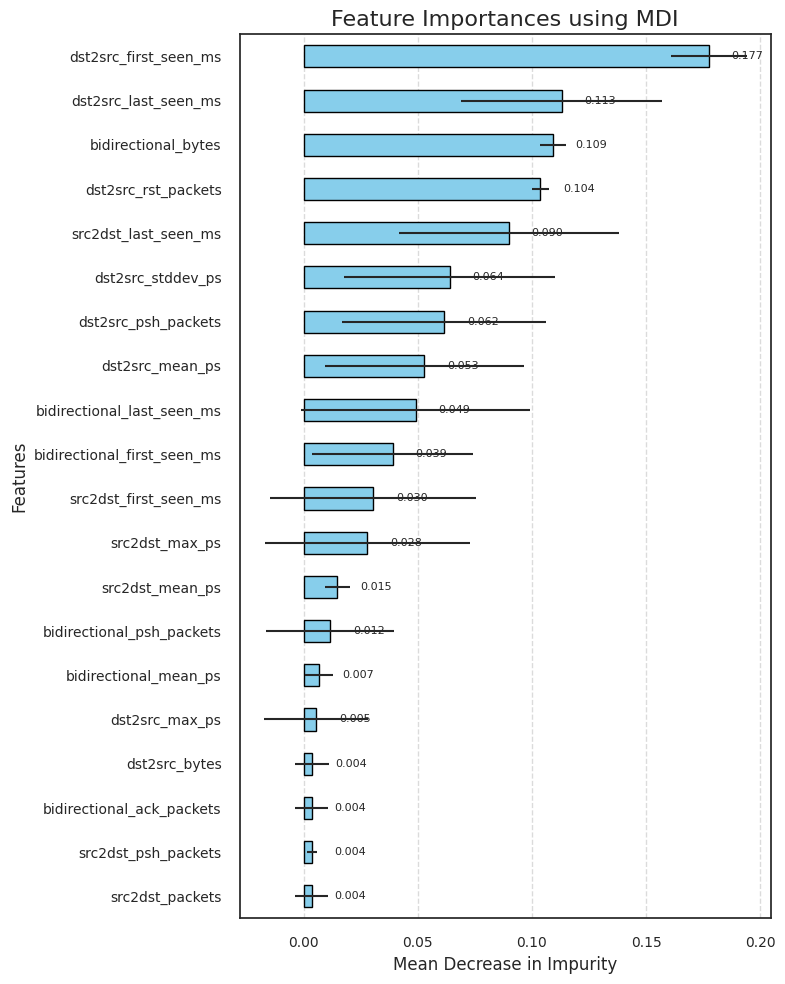

In [22]:
forest_importances = pd.Series(importances, index=X_res.columns)

sorted_indices = np.argsort(forest_importances)[::-1]
sorted_std = std[sorted_indices][:20] # Select only the first 20 features
sorted_importance = forest_importances[sorted_indices][:20]  # Select importance values for the first 20 features

# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 10))  # Adjust the figure size as needed for vertical display

# Create the vertical bar plot with error bars
sorted_importance.plot(kind='barh', xerr=sorted_std, ax=ax, color='skyblue', edgecolor='black')

# Set plot title and labels
ax.set_title("Feature Importances using MDI", fontsize=16)
ax.set_xlabel("Mean Decrease in Impurity", fontsize=12)
ax.set_ylabel("Features", fontsize=12)

# Customize ticks and grid
ax.tick_params(axis='both', which='major', labelsize=10)
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Invert y-axis to display most important feature at the top
ax.invert_yaxis()

# Add data labels at the end of each bar
for i, v in enumerate(sorted_importance):
    ax.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=8)

# Show the plot
plt.tight_layout()
plt.show()

Using interventional to stay "true to the model" since we will use this data to do feature reduction and we want also to understand how things work

In [23]:
%%time

explainer = fasttreeshap.TreeExplainer(rf, algorithm='auto', n_jobs=-1) 
sv = explainer(X_train)

CPU times: user 3.53 s, sys: 592 ms, total: 4.12 s
Wall time: 834 ms


In [24]:
rf.classes_

array(['BENIGN', 'Bot', 'DDoS', 'DoS GoldenEye', 'DoS Hulk',
       'DoS Slowhttptest', 'DoS slowloris', 'FTP-Patator', 'Heartbleed',
       'Infiltration', 'PortScan', 'SSH-Patator',
       'Web Attack - Brute Force', 'Web Attack - Sql Injection',
       'Web Attack - XSS'], dtype=object)

## Benign shap

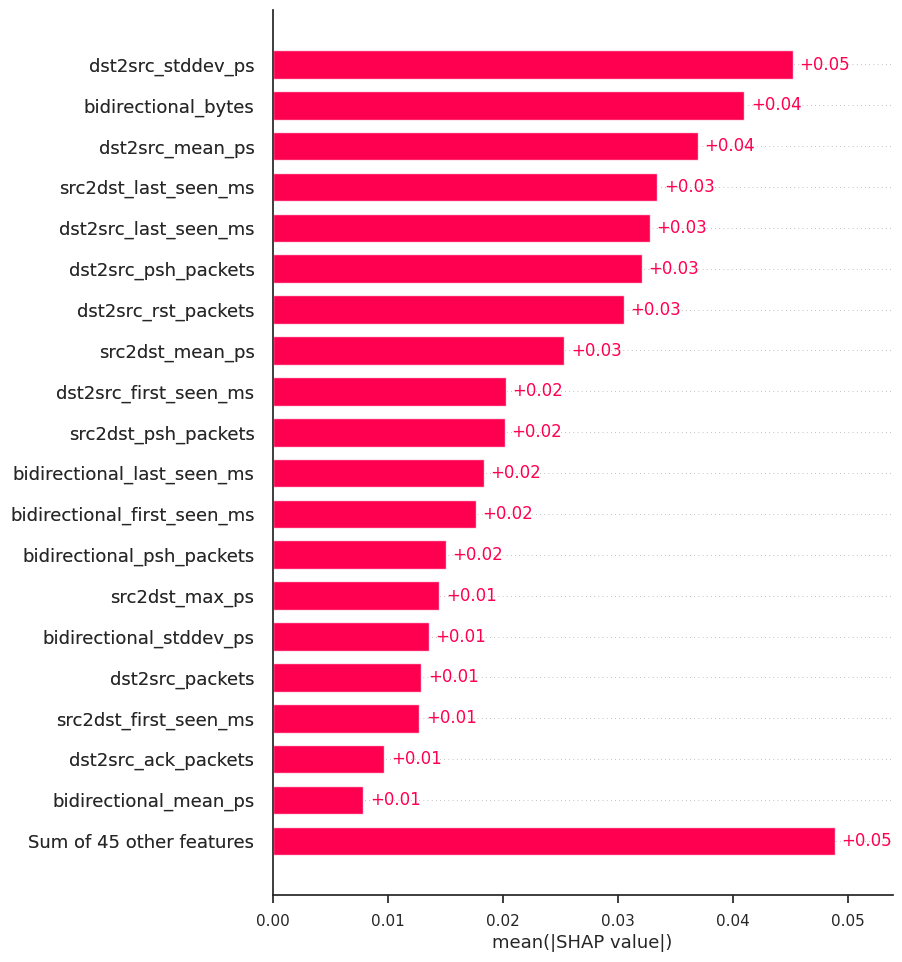

In [25]:
exp = Explanation(sv.values[:,:,0], 
                  sv.base_values[:,0], 
                  data=X_train, 
                  feature_names=X_res.columns)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

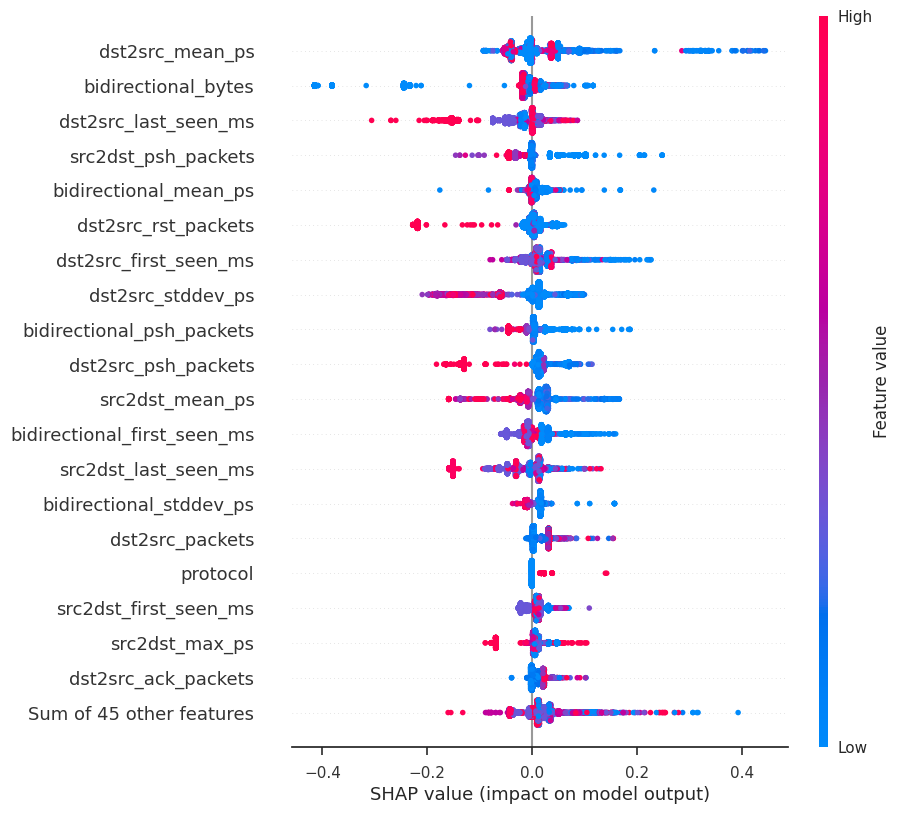

In [26]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

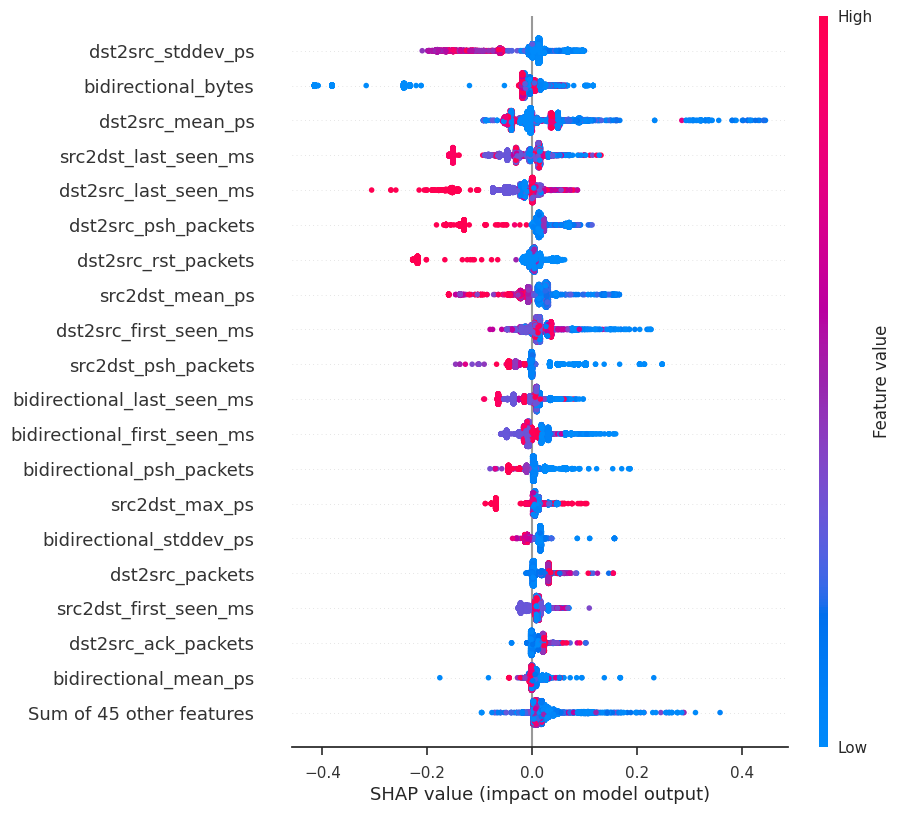

In [27]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## Bot shap

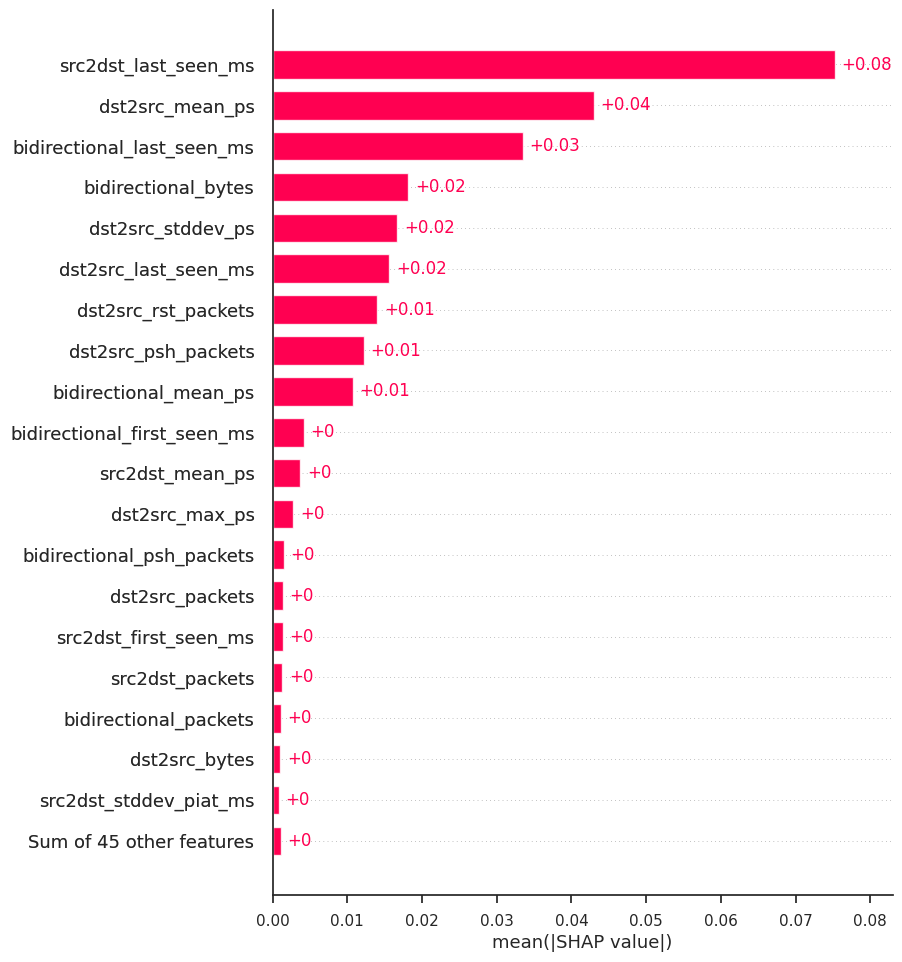

In [28]:
exp = Explanation(sv.values[:,:,1], 
                  sv.base_values[:,1], 
                  data=X_train, 
                  feature_names=X_res.columns)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)

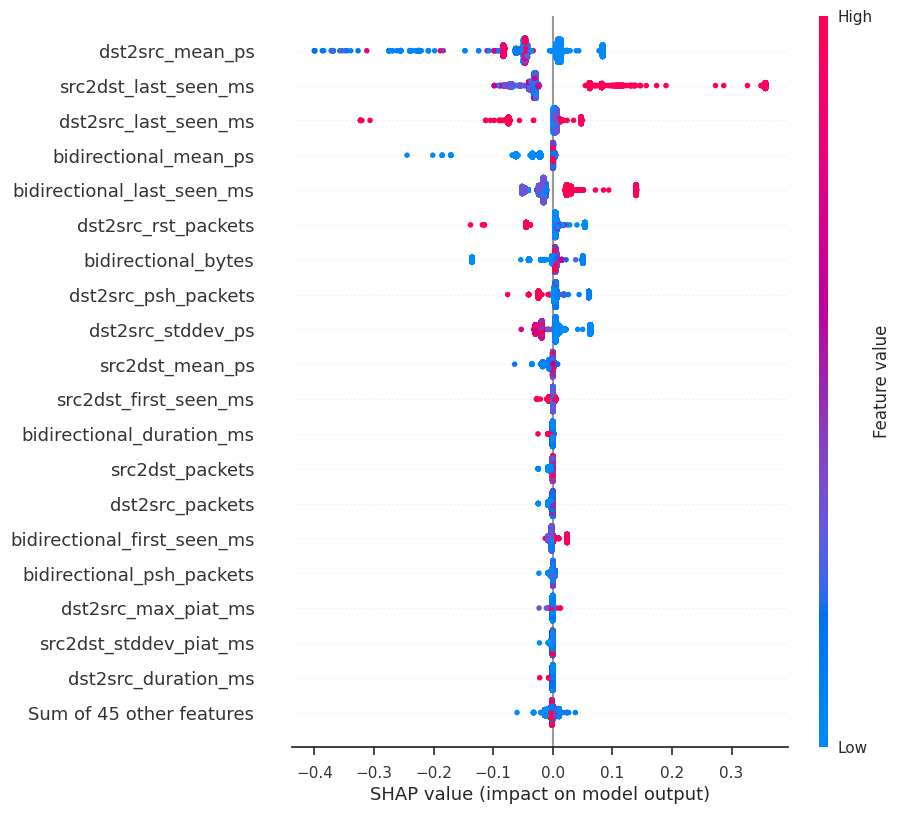

In [29]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

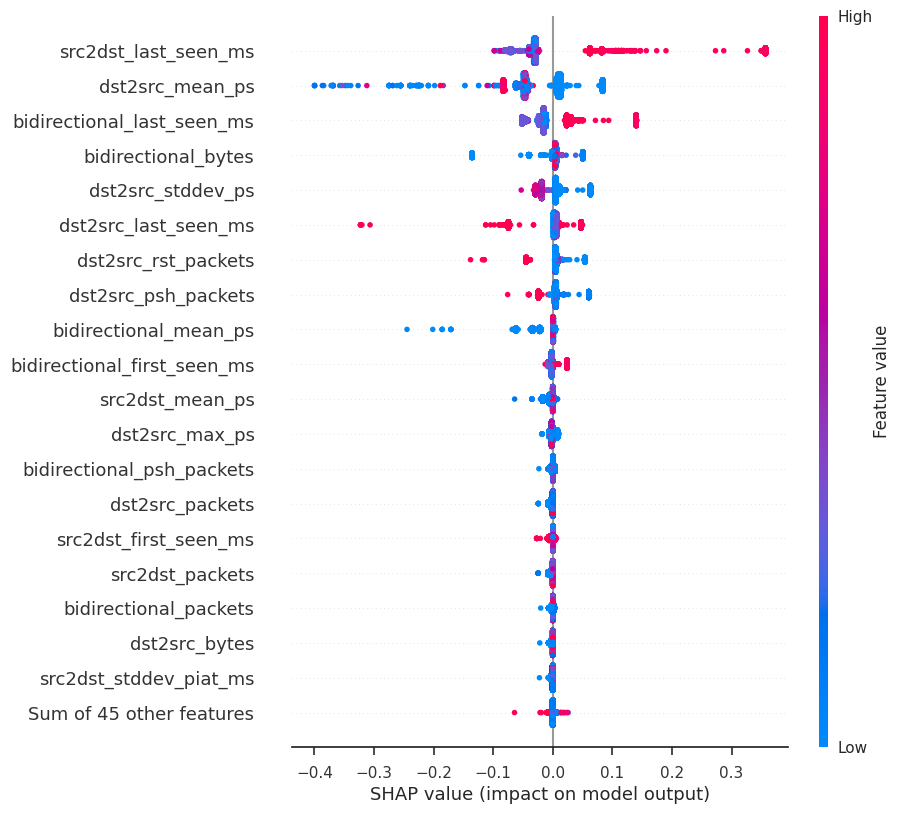

In [30]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## DDoS shap

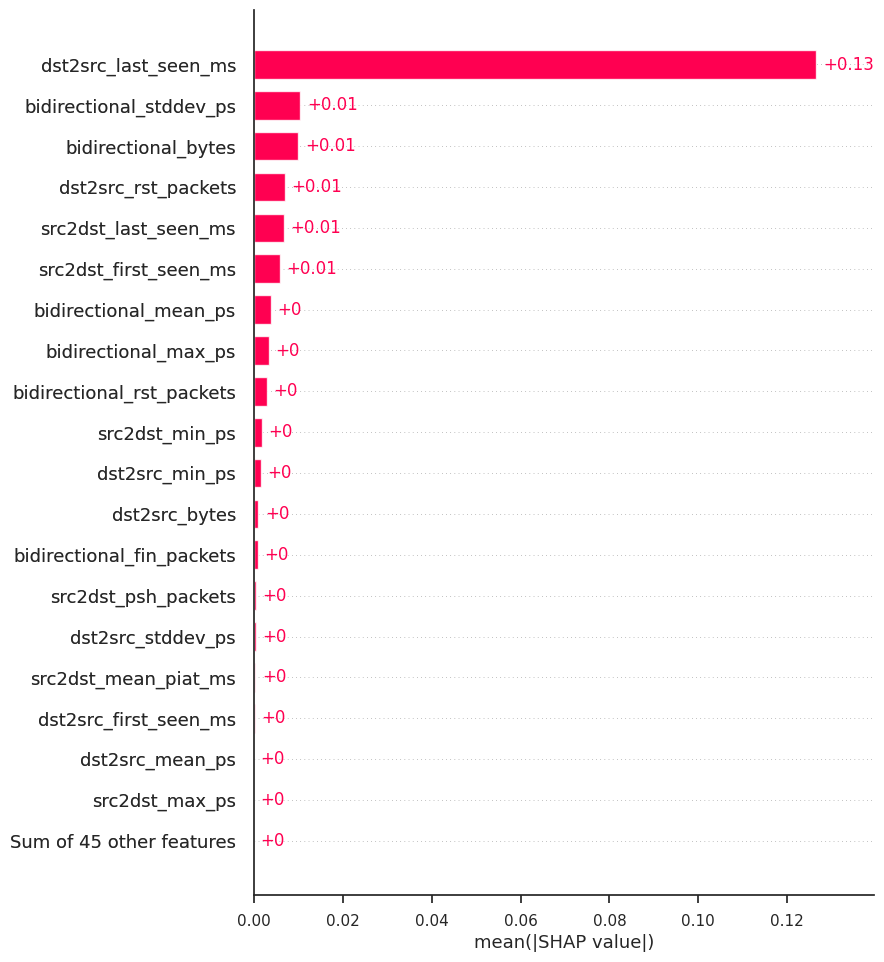

In [31]:
exp = Explanation(sv.values[:,:,2], 
                  sv.base_values[:,2], 
                  data=X_train, 
                  feature_names=X_res.columns)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)

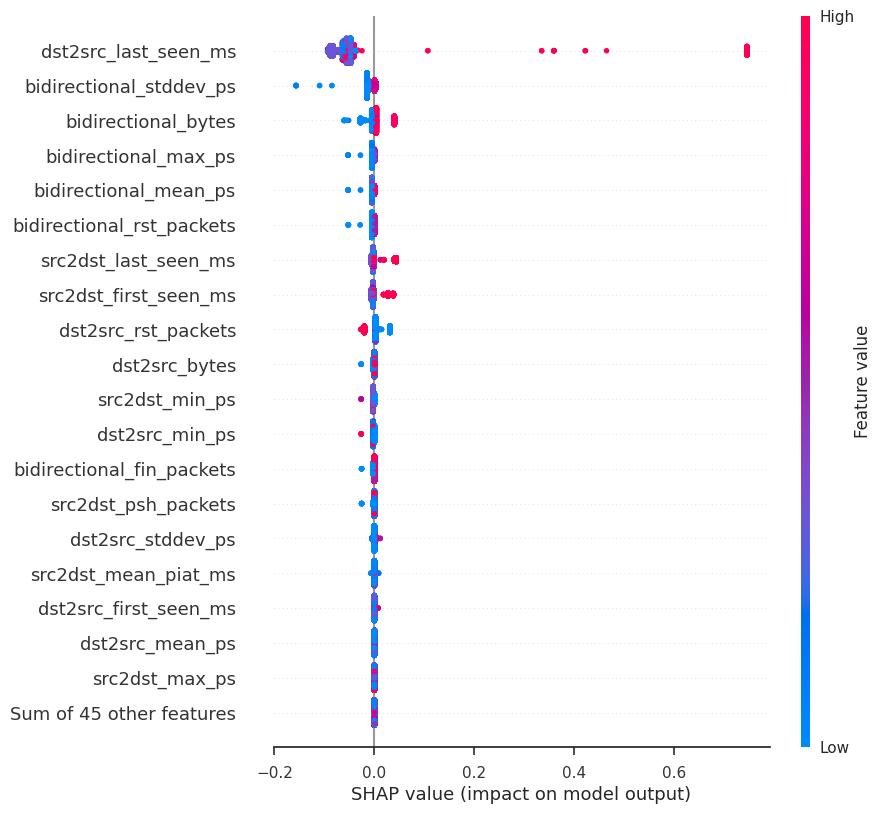

In [32]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

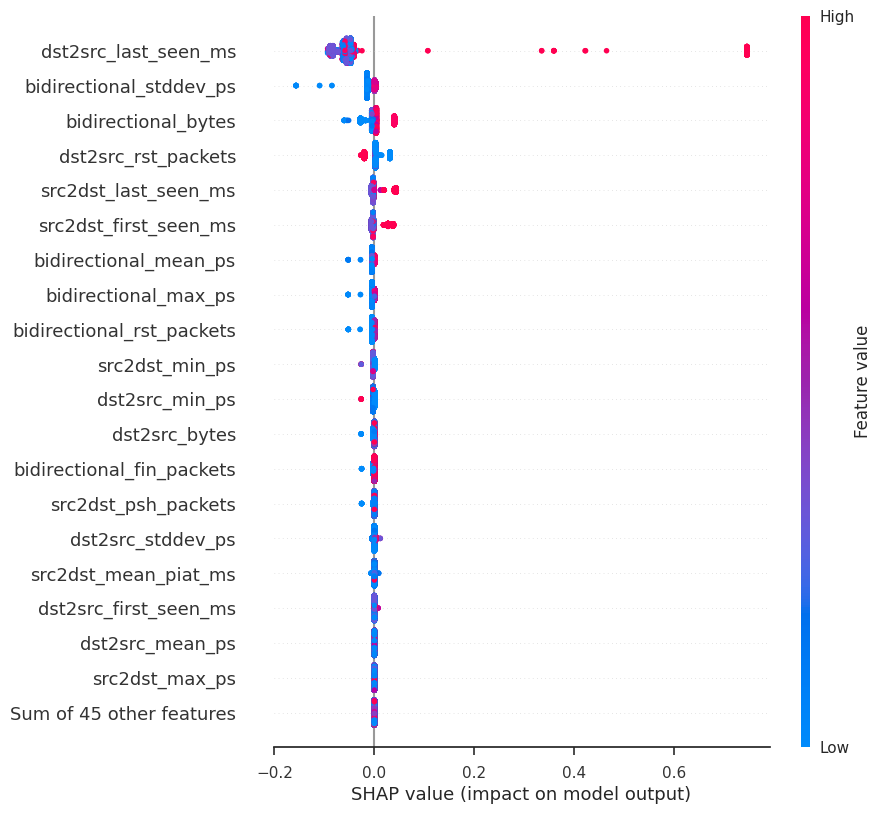

In [33]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## DoS GoldenEye shap

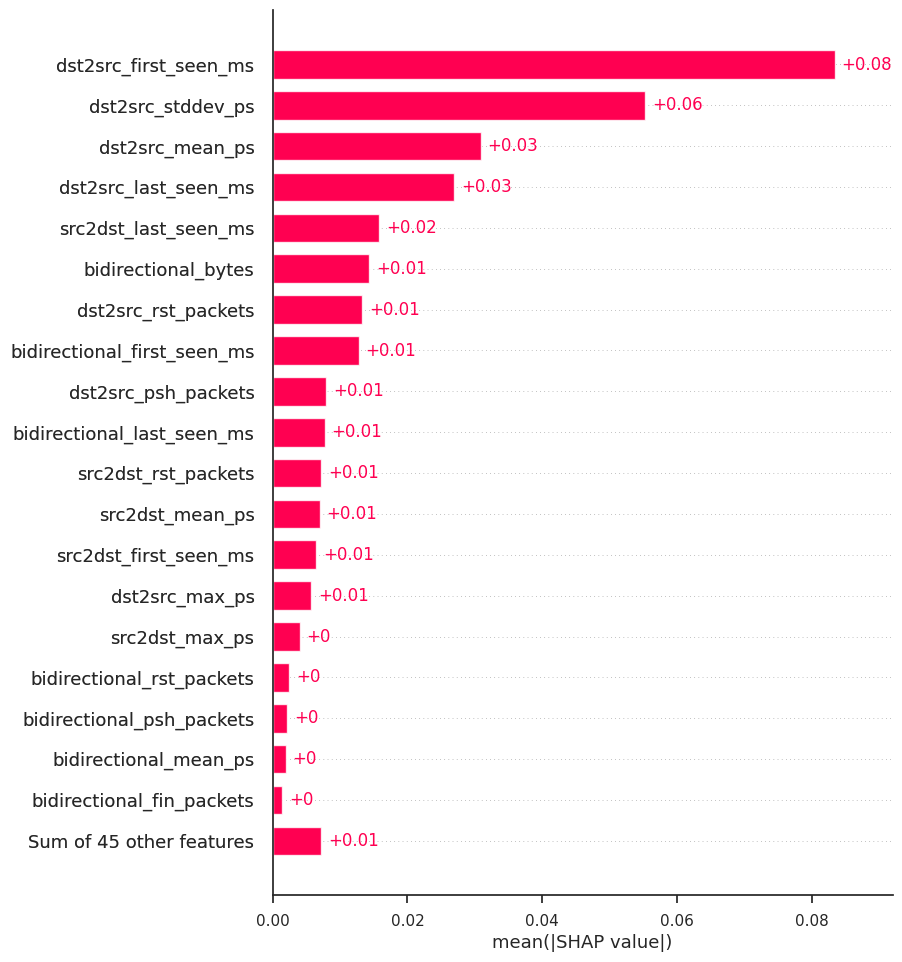

In [34]:
exp = Explanation(sv.values[:,:,3], 
                  sv.base_values[:,3], 
                  data=X_train, 
                  feature_names=X_res.columns)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

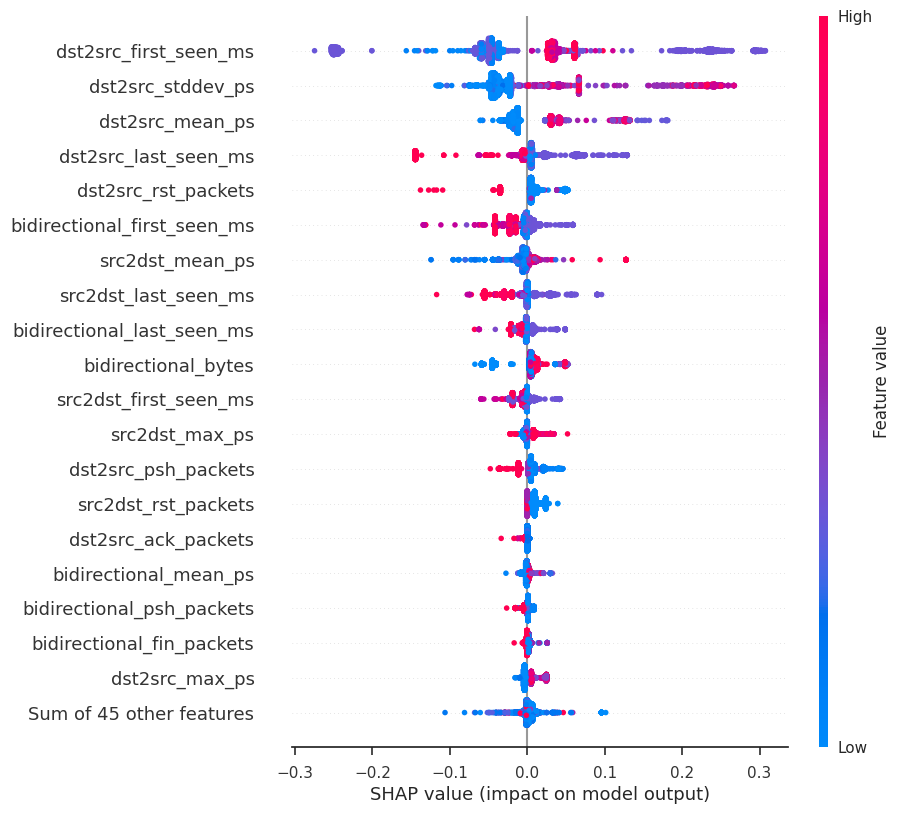

In [35]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

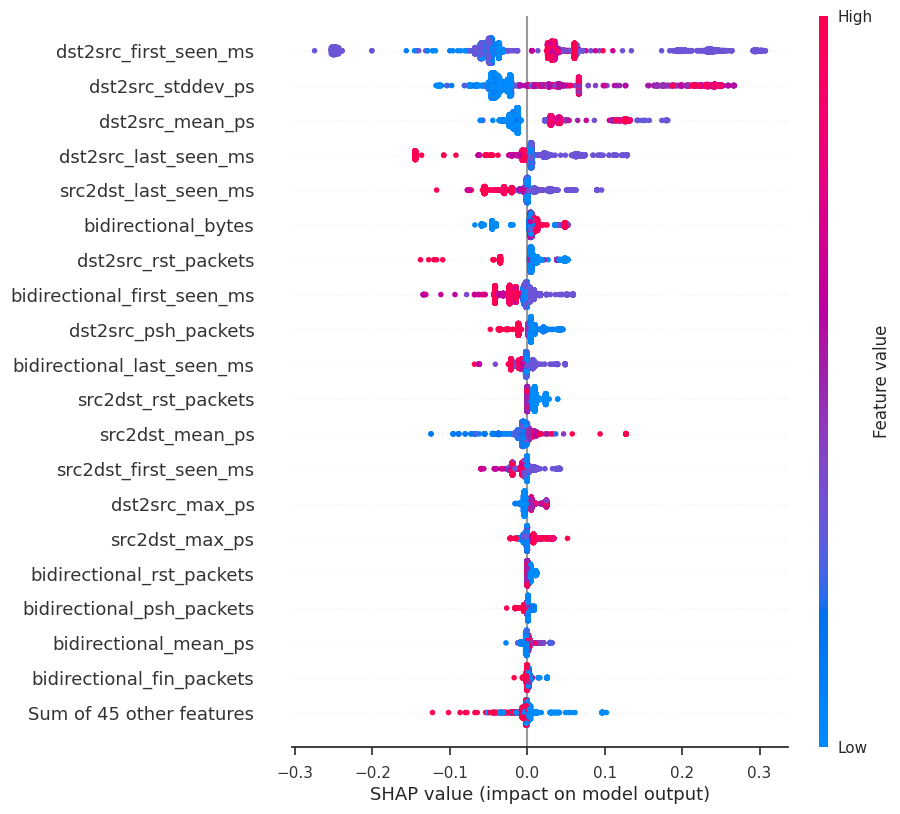

In [36]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## DoS Hulk shap

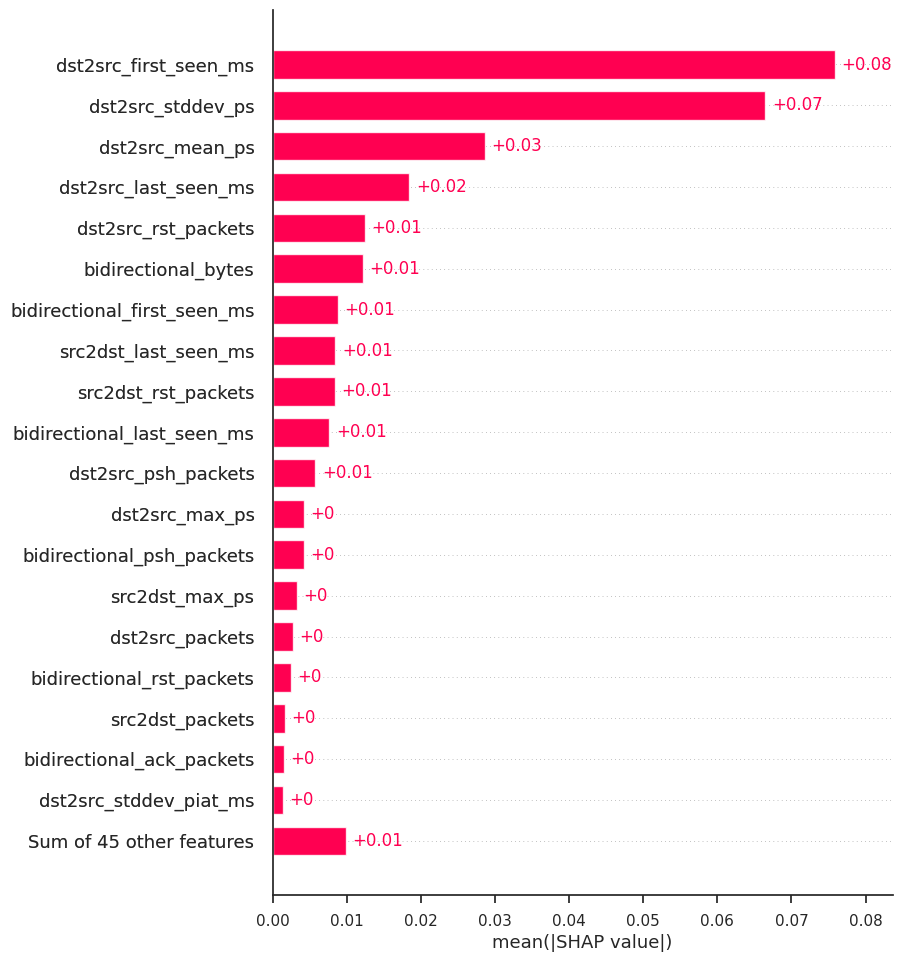

In [37]:
exp = Explanation(sv.values[:,:,4], 
                  sv.base_values[:,4], 
                  data=X_train, 
                  feature_names=X_res.columns)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

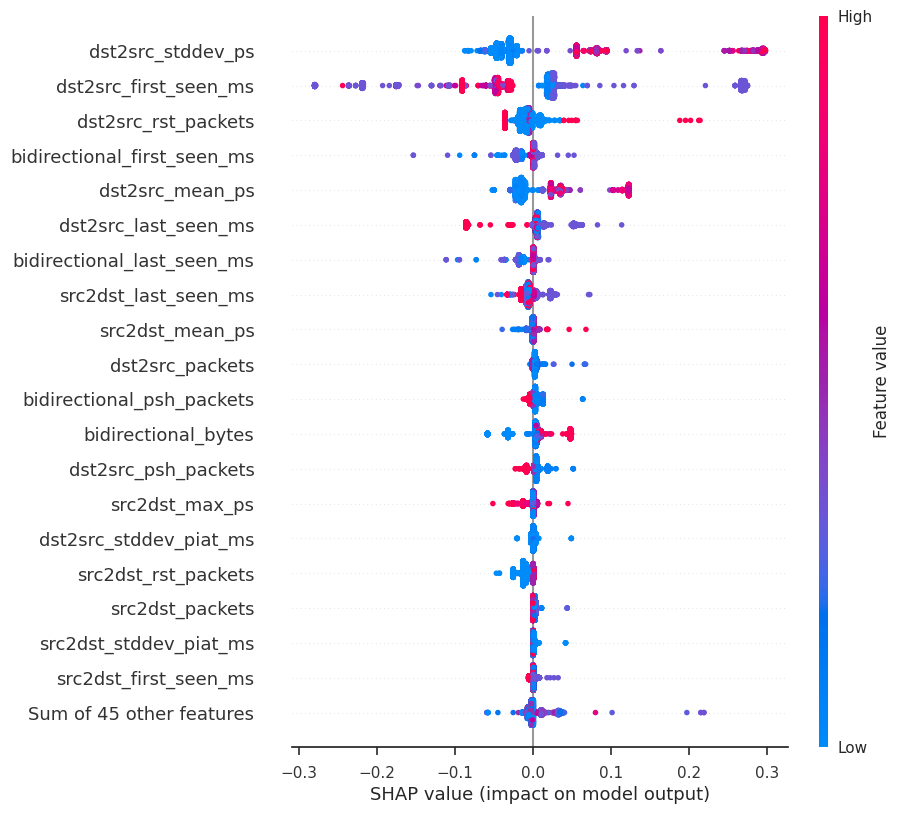

In [38]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

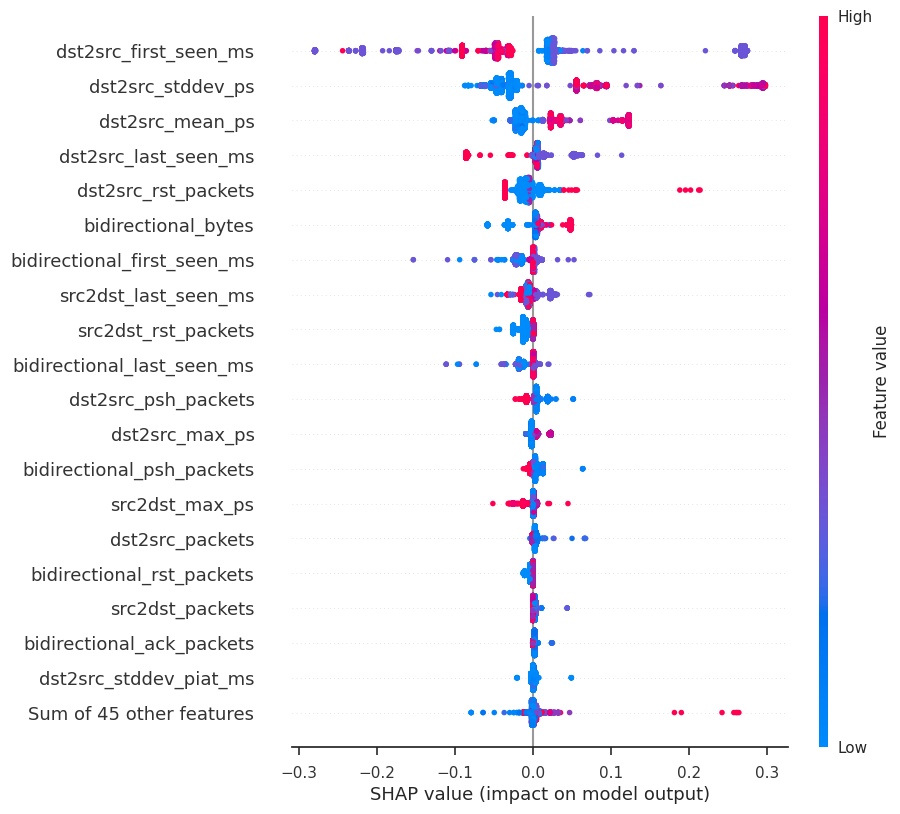

In [39]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## DoS Slowhttptest shap

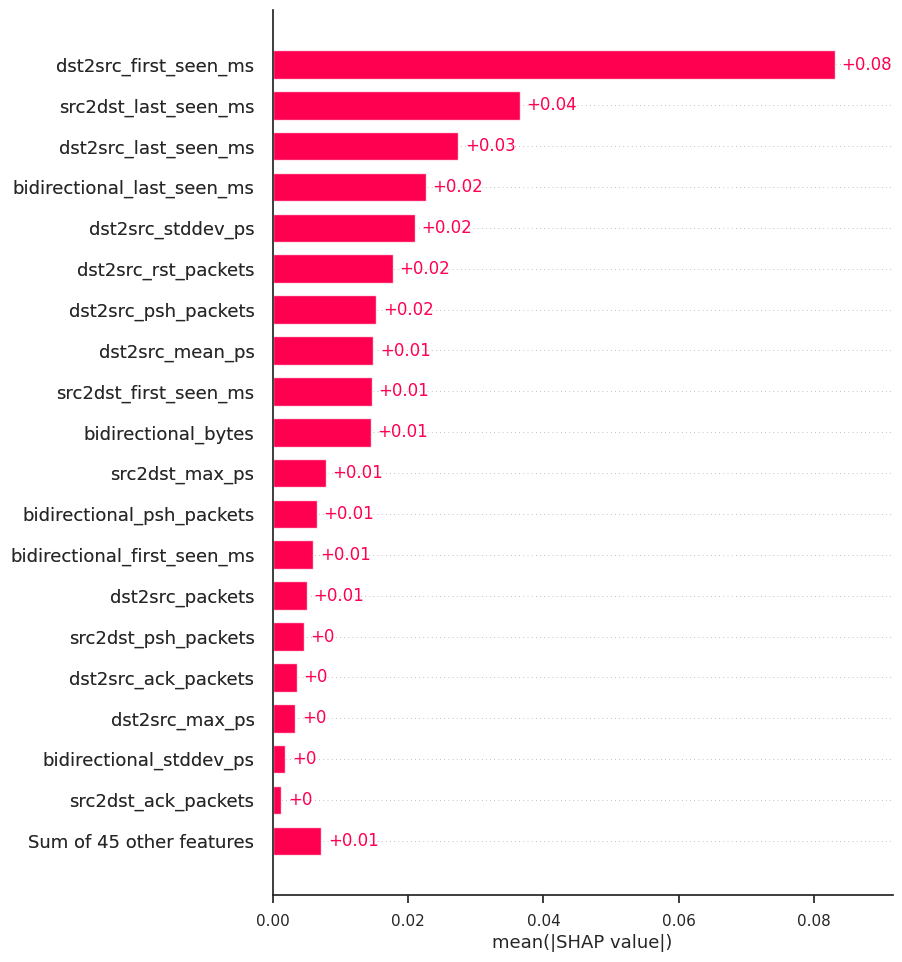

In [40]:
exp = Explanation(sv.values[:,:,5], 
                  sv.base_values[:,5], 
                  data=X_train, 
                  feature_names=X_res.columns)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

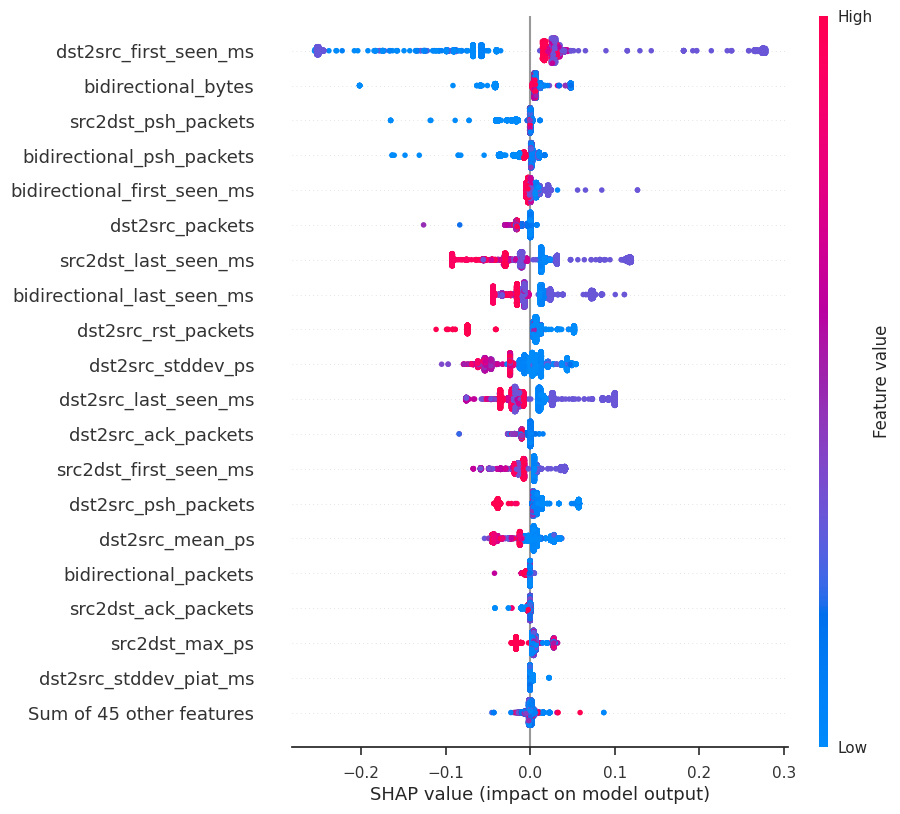

In [41]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

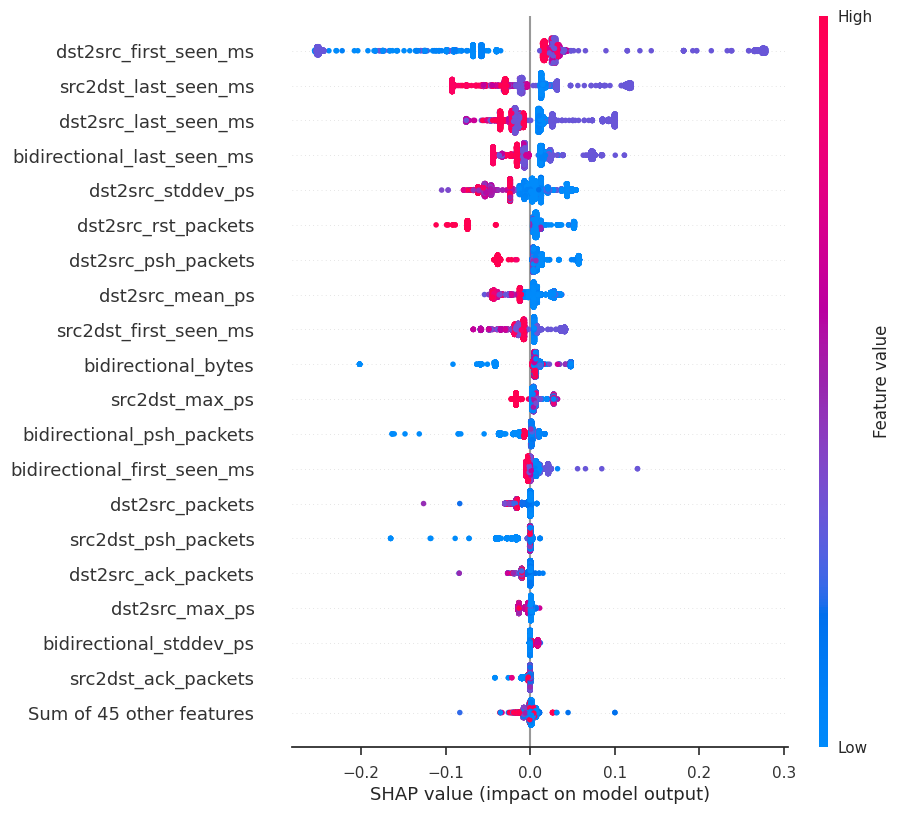

In [42]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## DoS slowloris shap

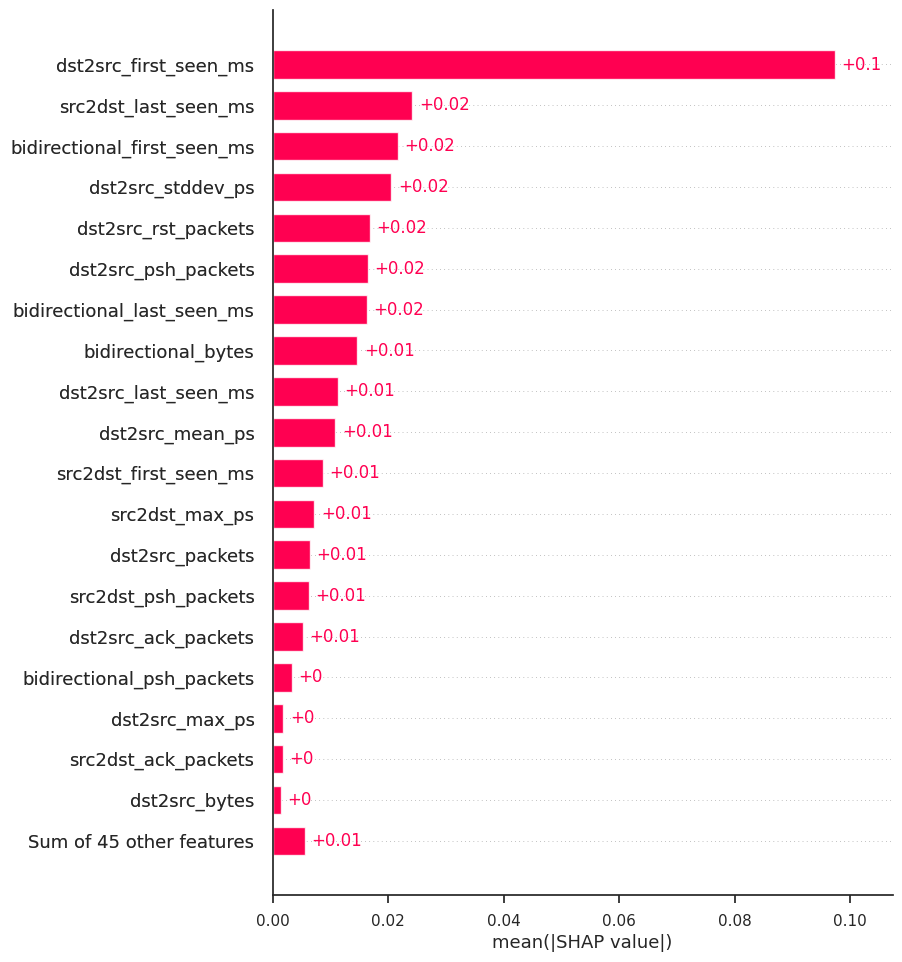

In [43]:
exp = Explanation(sv.values[:,:,6], 
                  sv.base_values[:,6], 
                  data=X_train, 
                  feature_names=X_res.columns)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

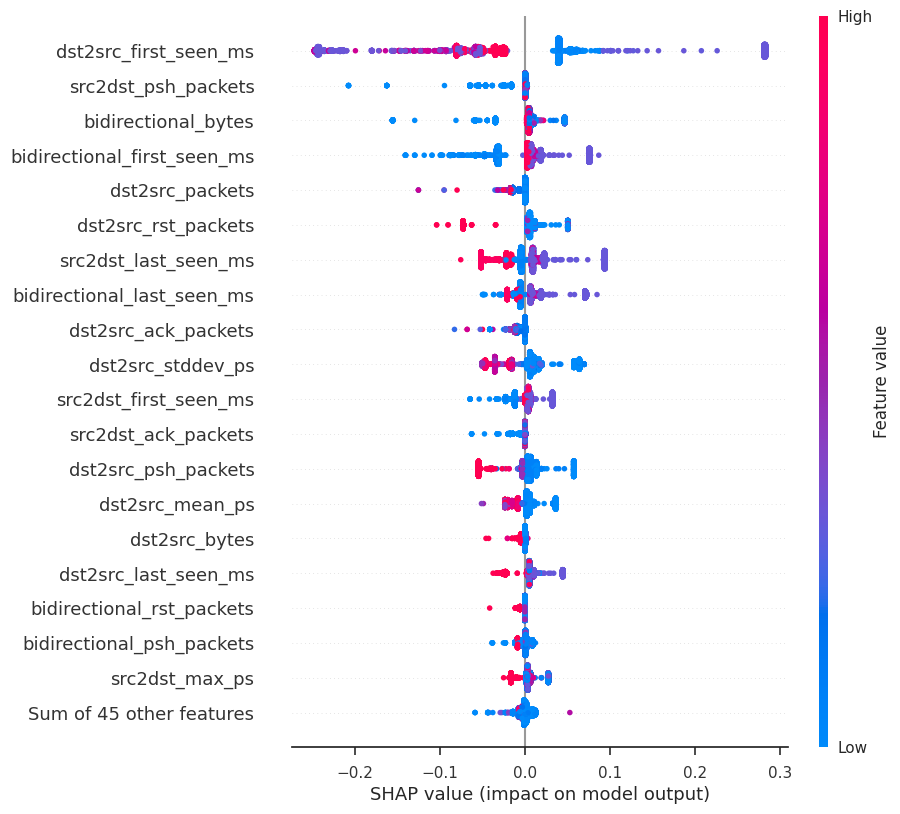

In [44]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

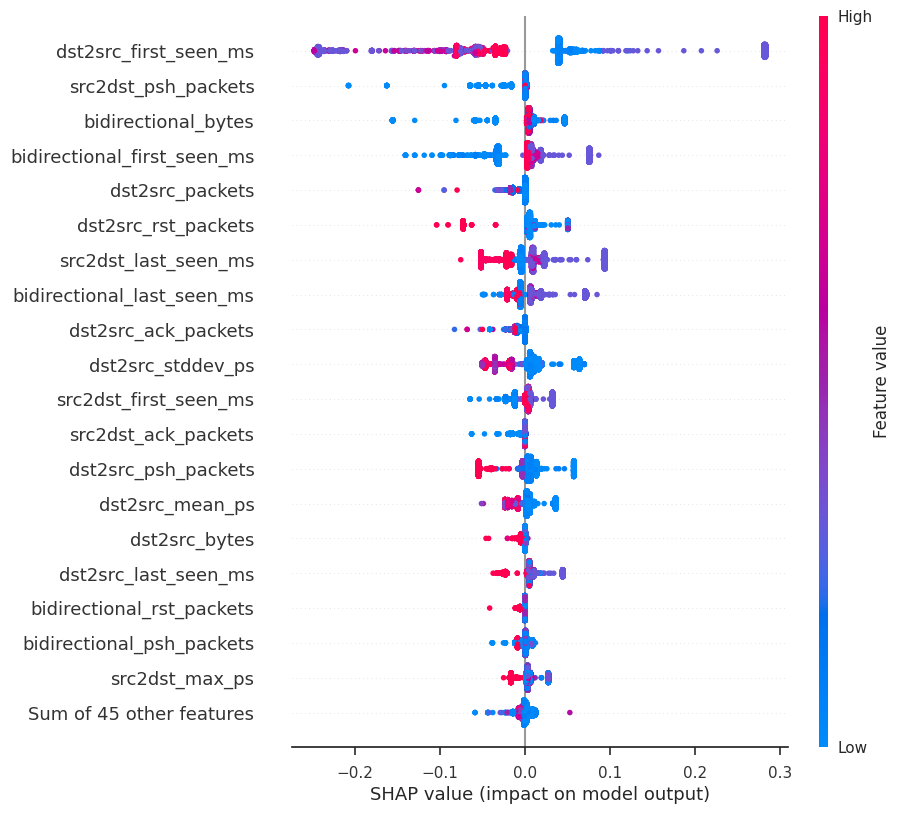

In [45]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

## FTP-Patator shap

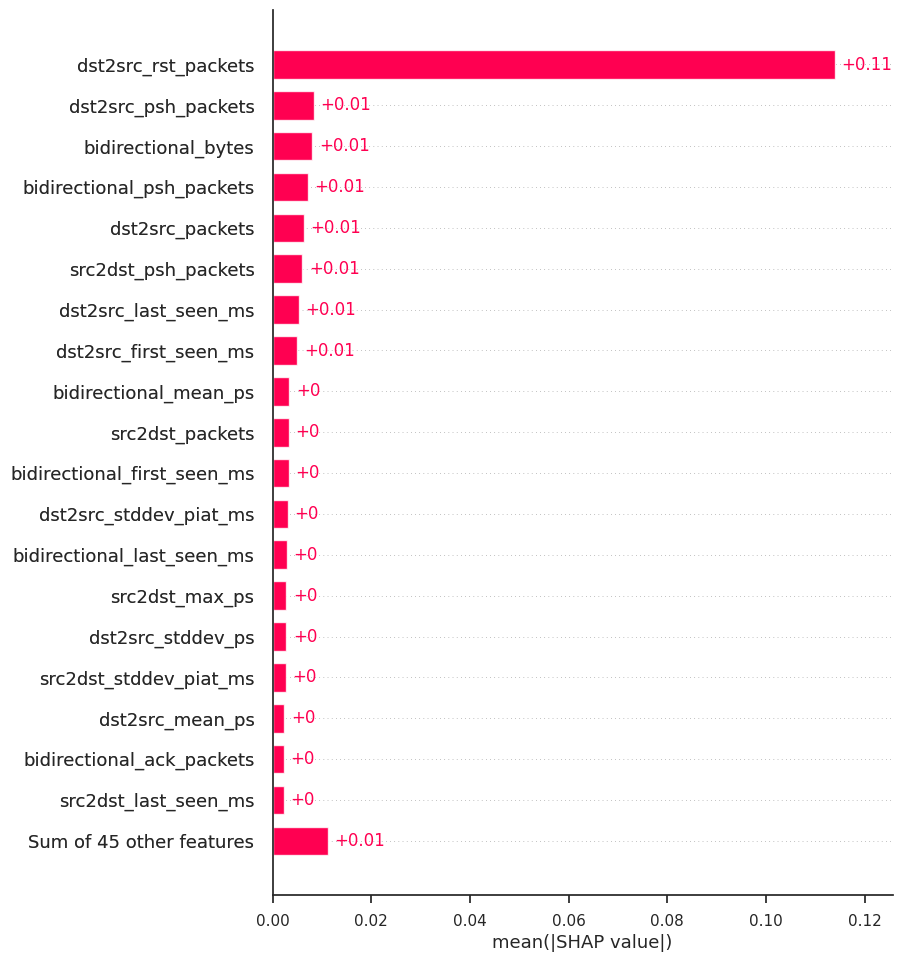

In [46]:
exp = Explanation(sv.values[:,:,7], 
                  sv.base_values[:,7], 
                  data=X_train, 
                  feature_names=X_res.columns)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

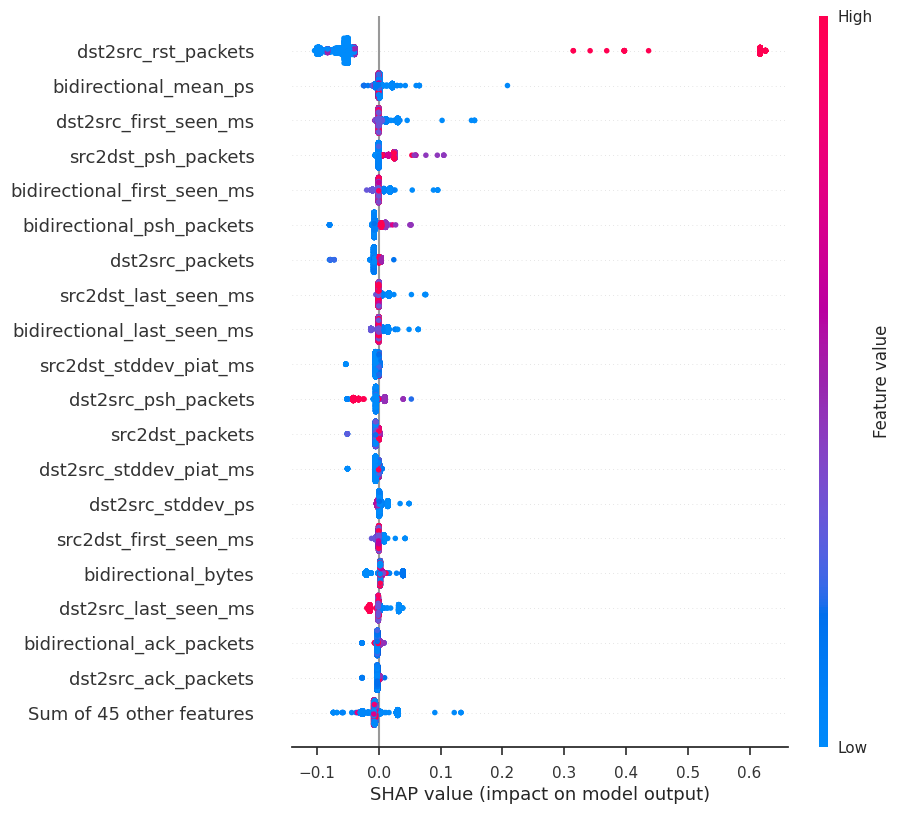

In [47]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

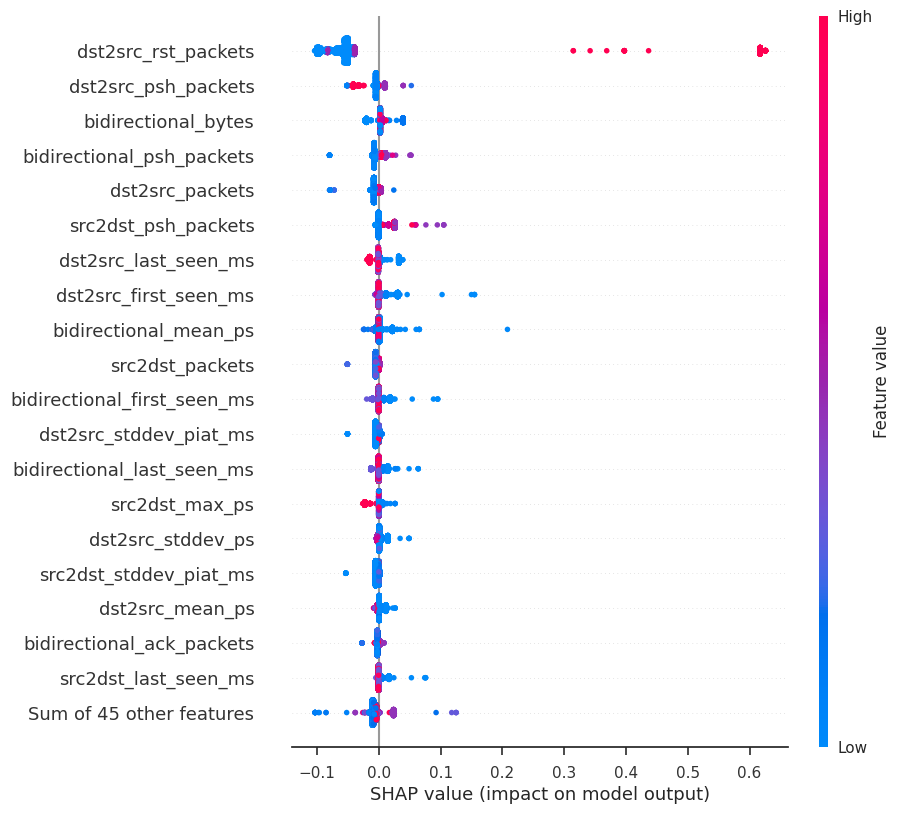

In [48]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## Heartbleed shap

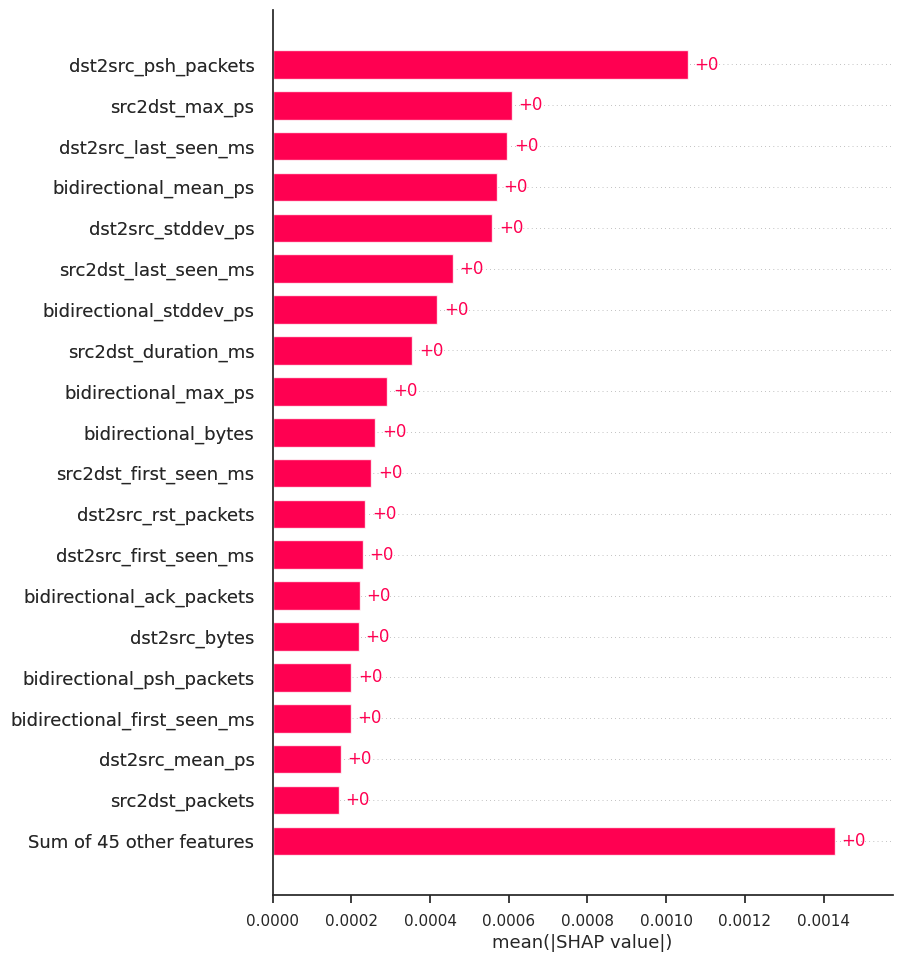

In [49]:
exp = Explanation(sv.values[:,:,8], 
                  sv.base_values[:,8], 
                  data=X_train, 
                  feature_names=X_res.columns)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

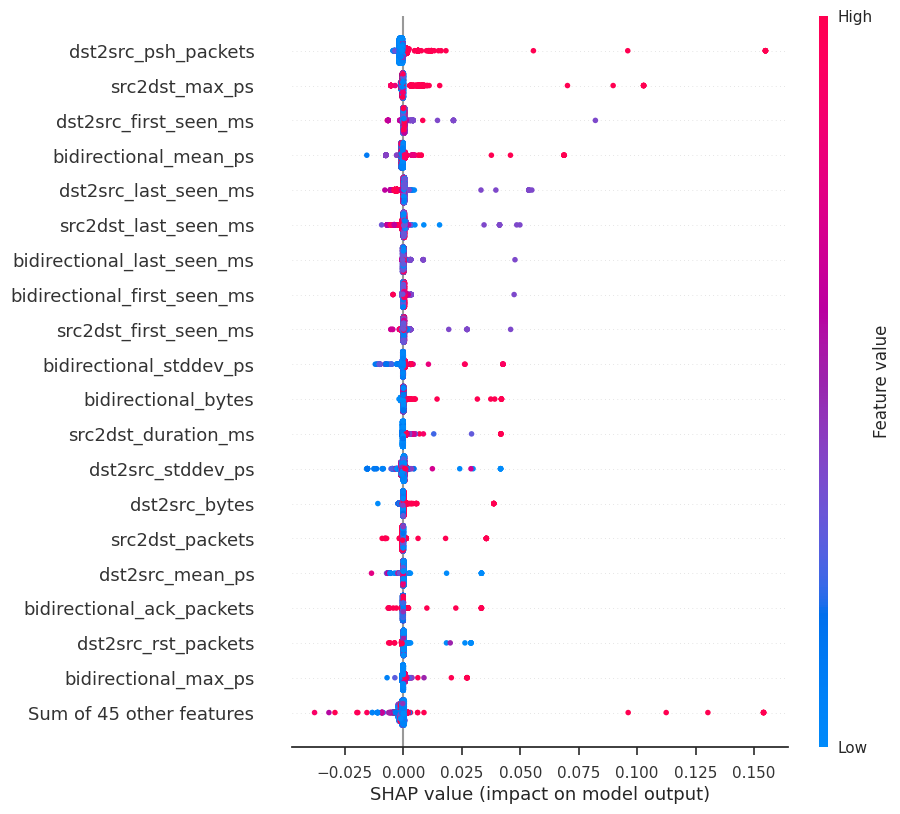

In [50]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

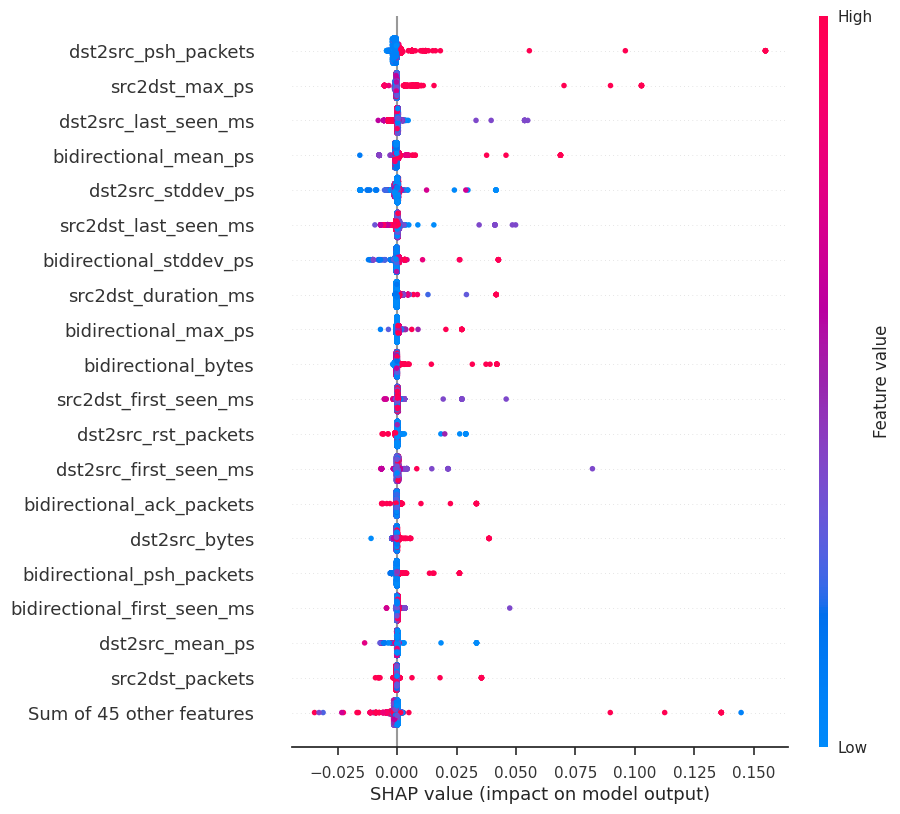

In [51]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## Infiltration shap

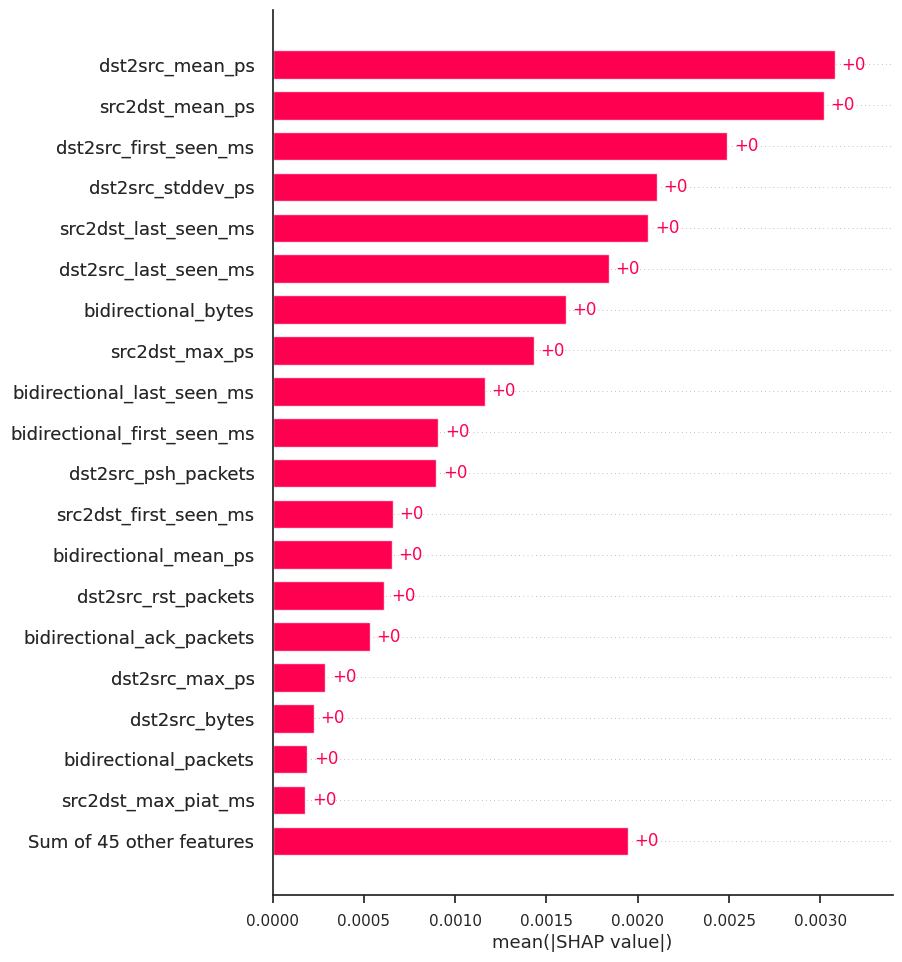

In [52]:
exp = Explanation(sv.values[:,:,9], 
                  sv.base_values[:,9], 
                  data=X_train, 
                  feature_names=X_res.columns)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

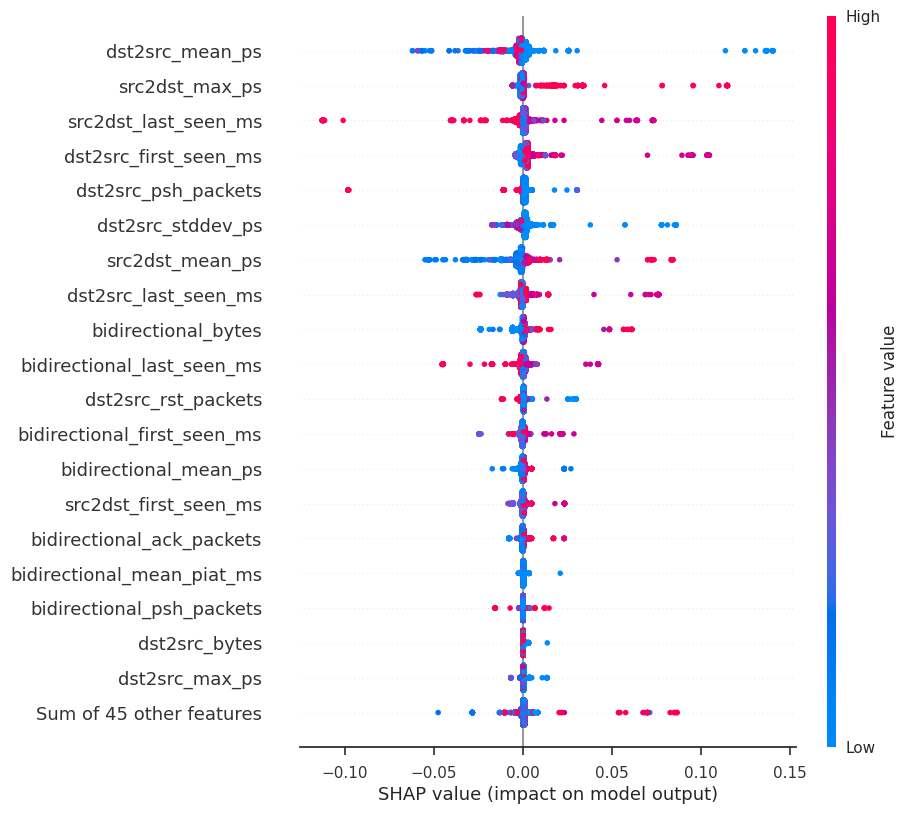

In [53]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

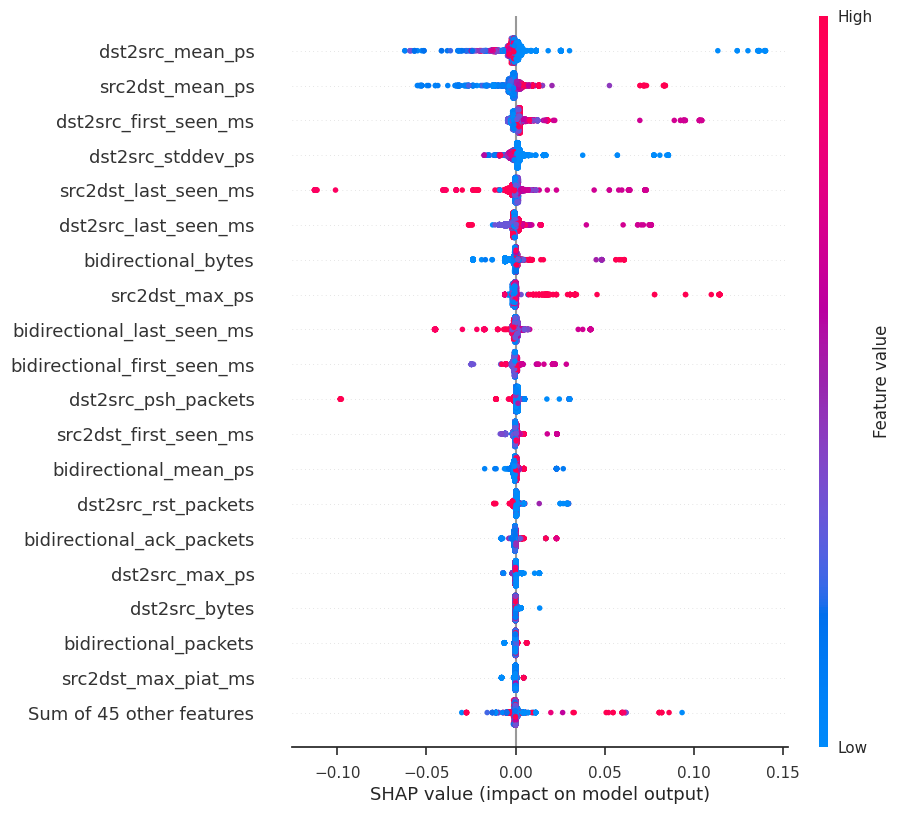

In [54]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## PortScan shap

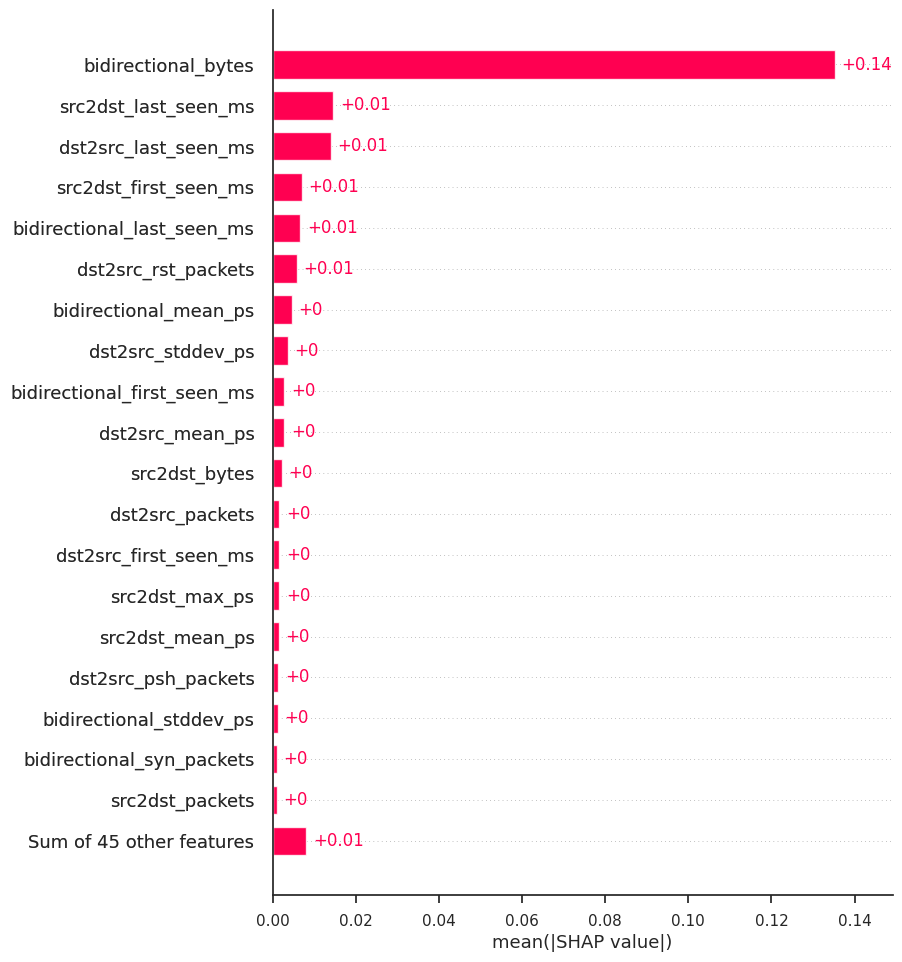

In [55]:
exp = Explanation(sv.values[:,:,10], 
                  sv.base_values[:,10], 
                  data=X_train, 
                  feature_names=X_res.columns)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

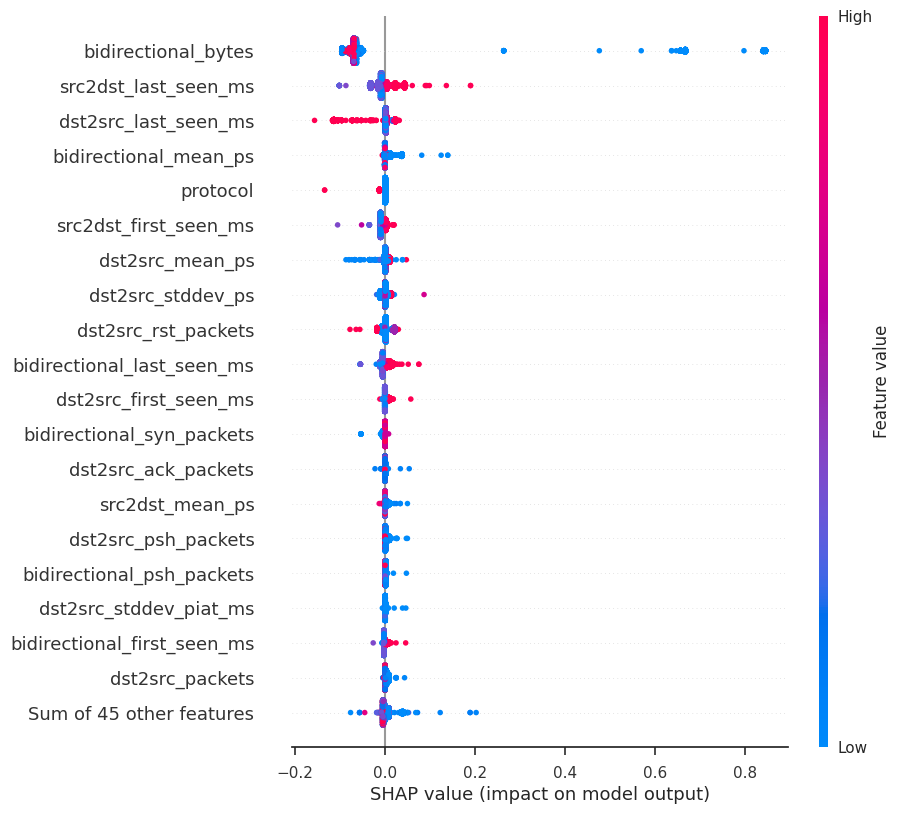

In [56]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

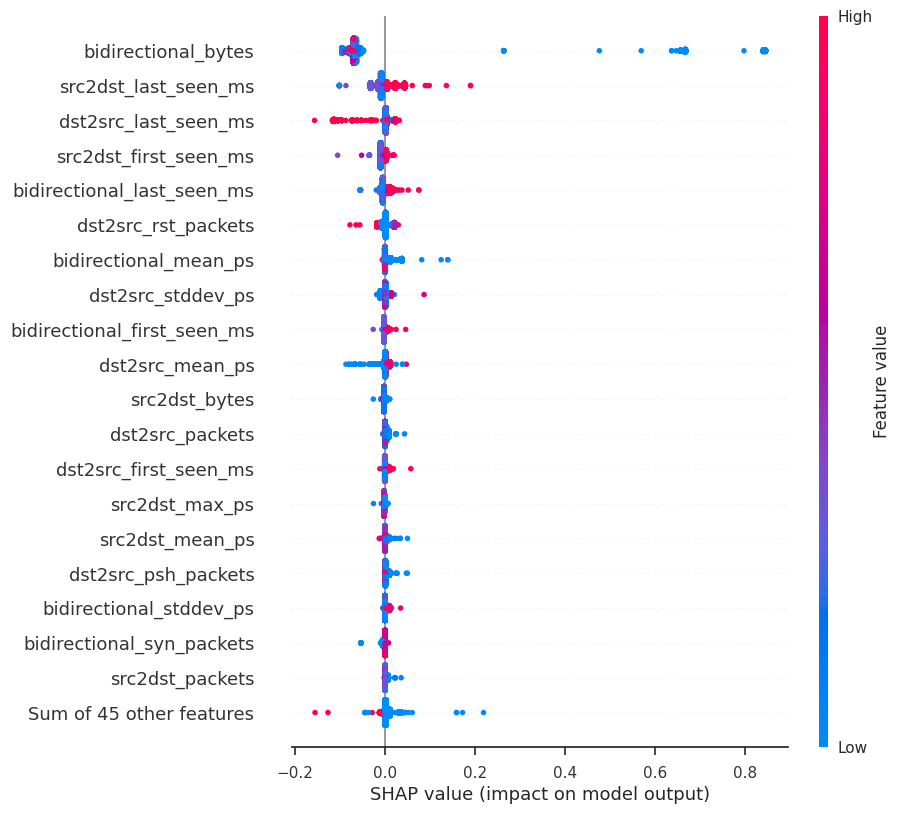

In [57]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## SSH-Patator shap

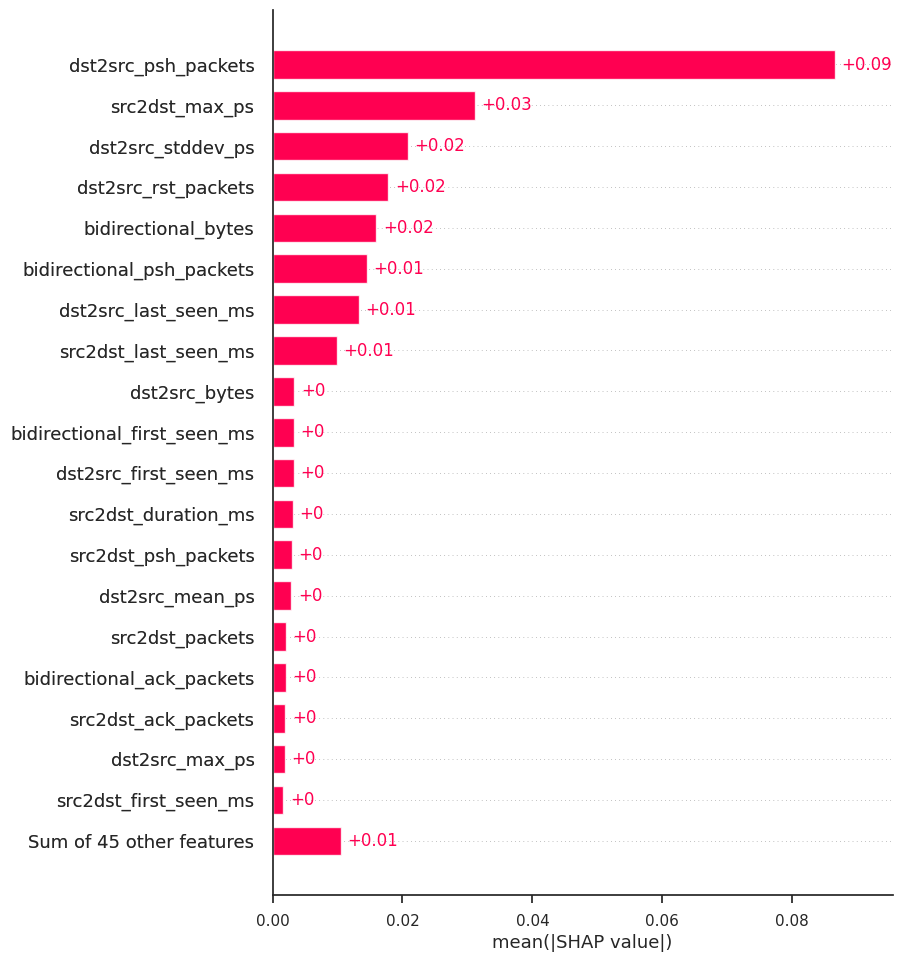

In [58]:
exp = Explanation(sv.values[:,:,11], 
                  sv.base_values[:,11], 
                  data=X_train, 
                  feature_names=X_res.columns)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

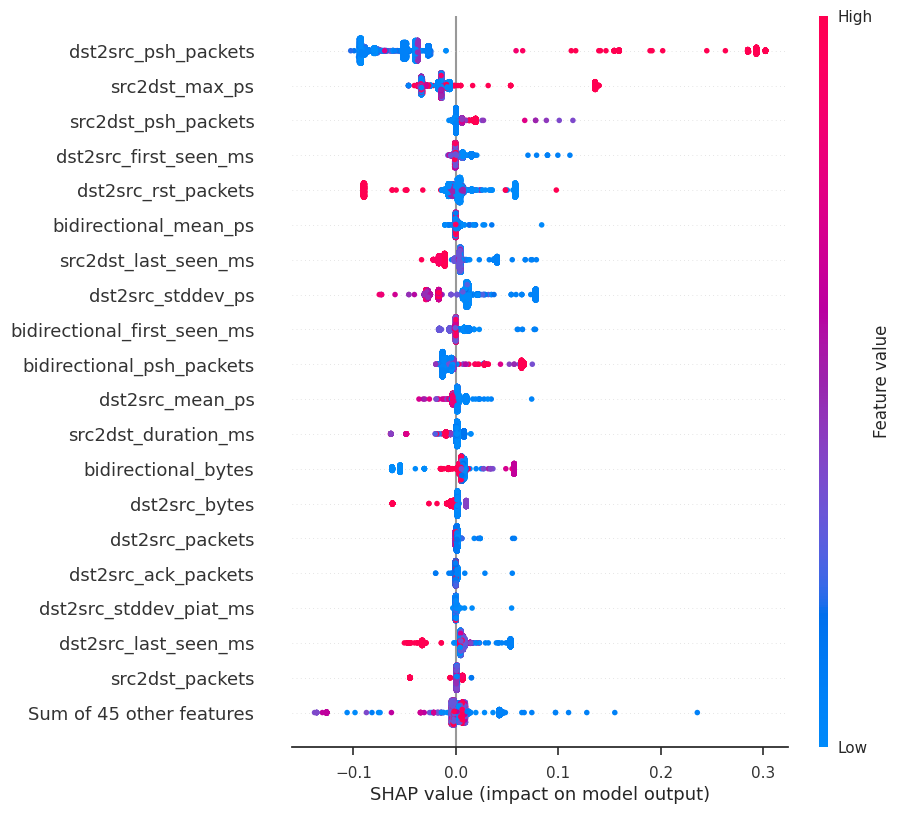

In [59]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

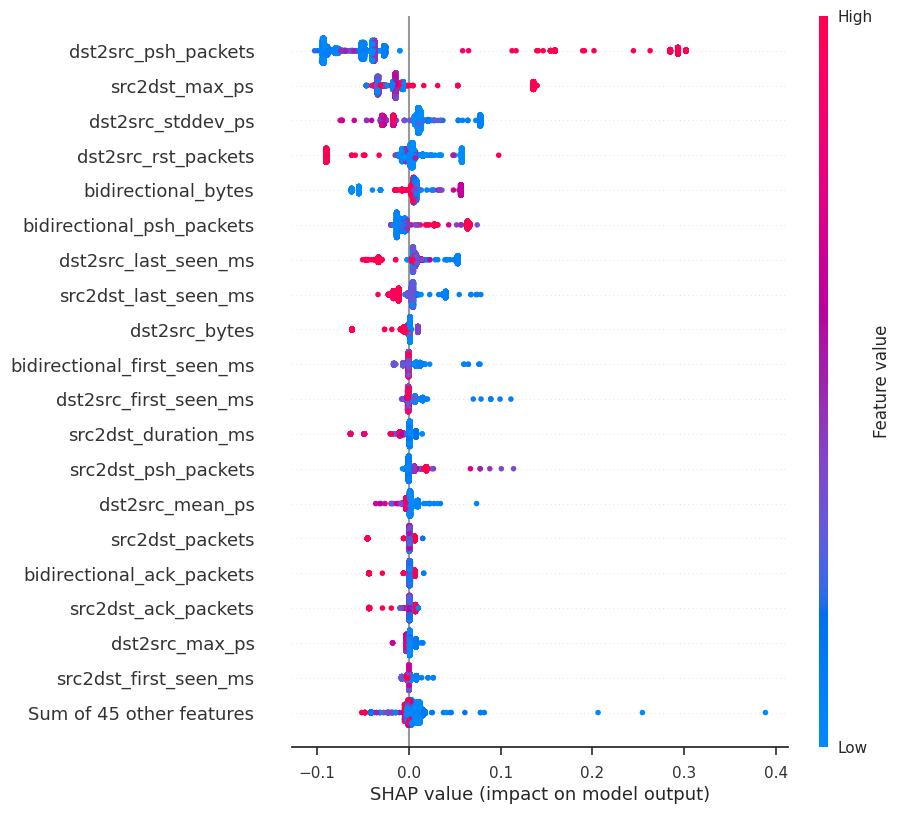

In [60]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## Web Attack - Brute Force shap

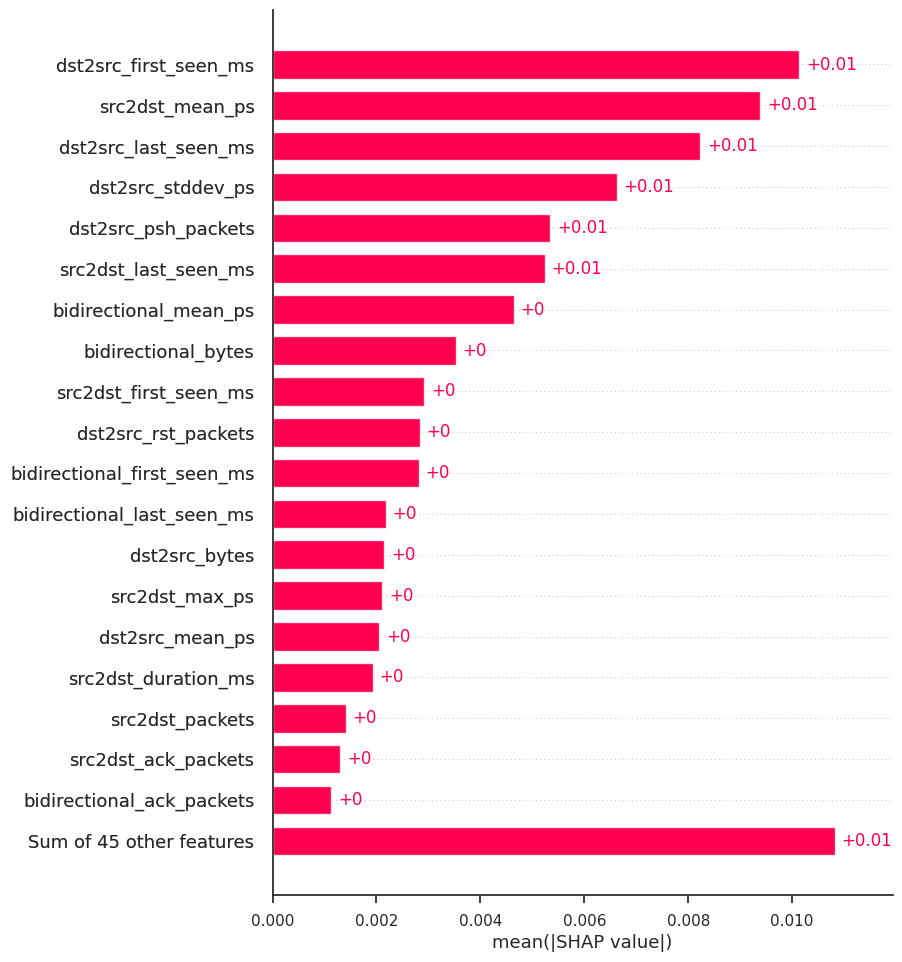

In [61]:
exp = Explanation(sv.values[:,:,12], 
                  sv.base_values[:,12], 
                  data=X_train, 
                  feature_names=X_res.columns)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

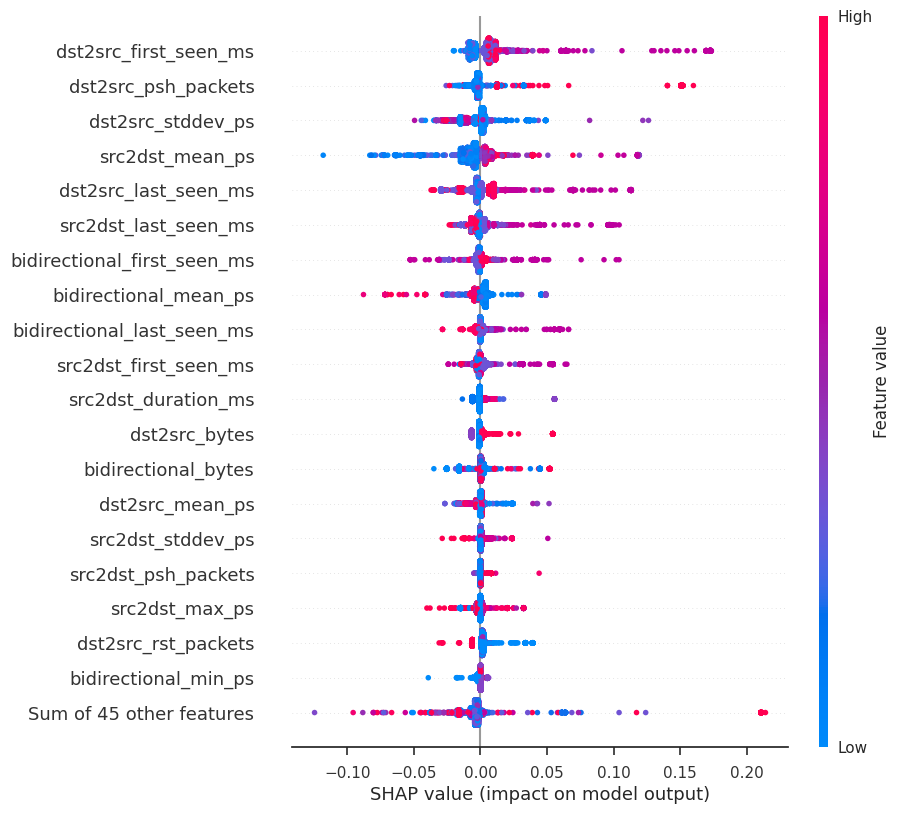

In [62]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

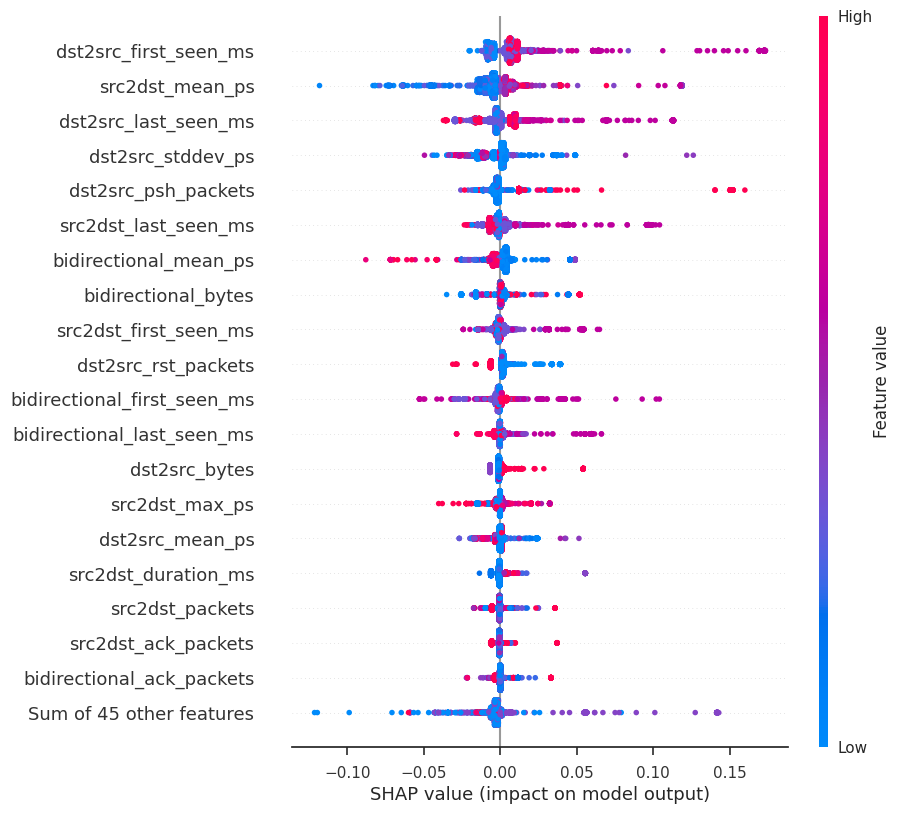

In [63]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## Web Attack - Sql Injection shap

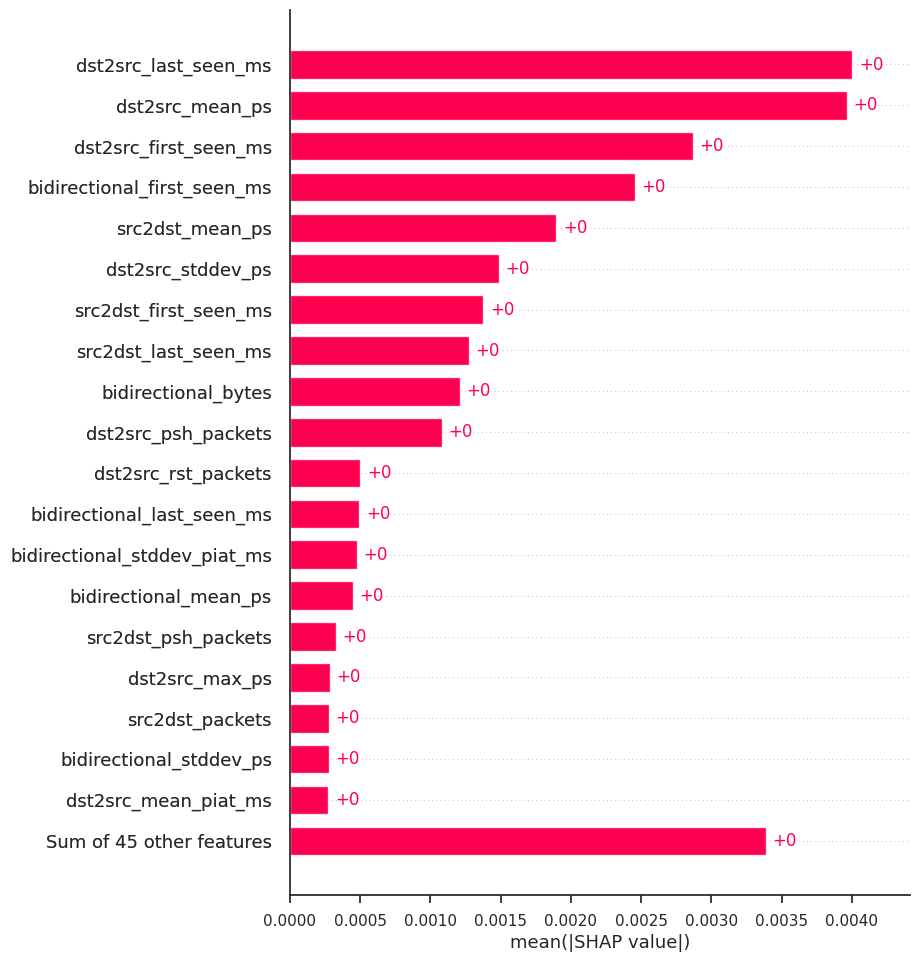

In [64]:
exp = Explanation(sv.values[:,:,13], 
                  sv.base_values[:,13], 
                  data=X_train, 
                  feature_names=X_res.columns)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

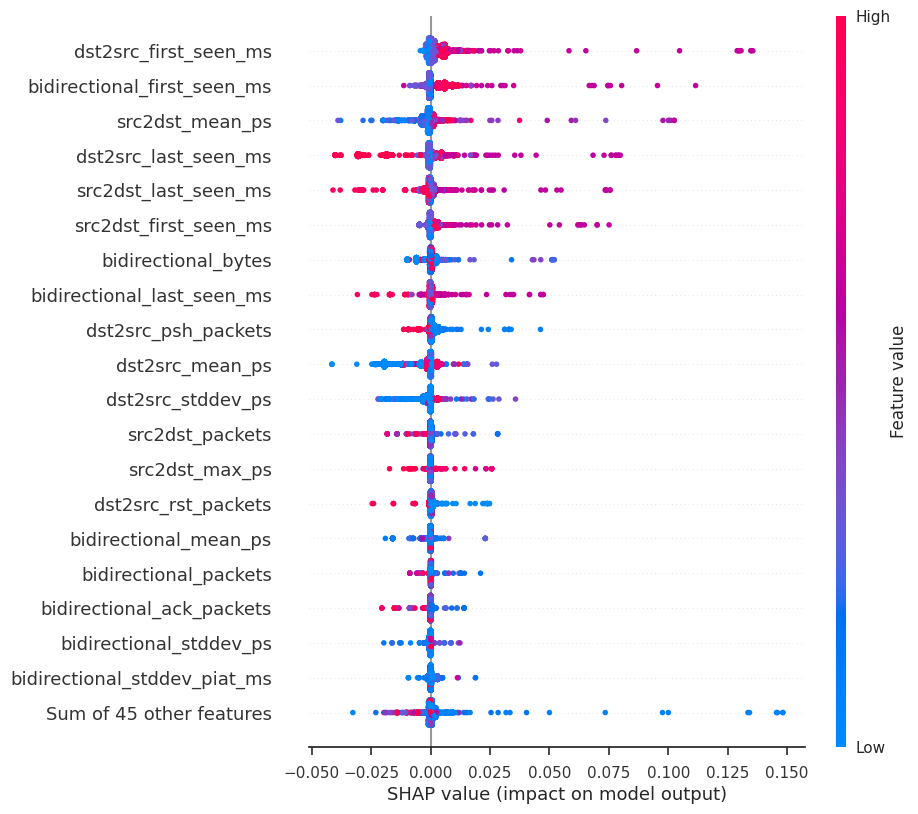

In [65]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

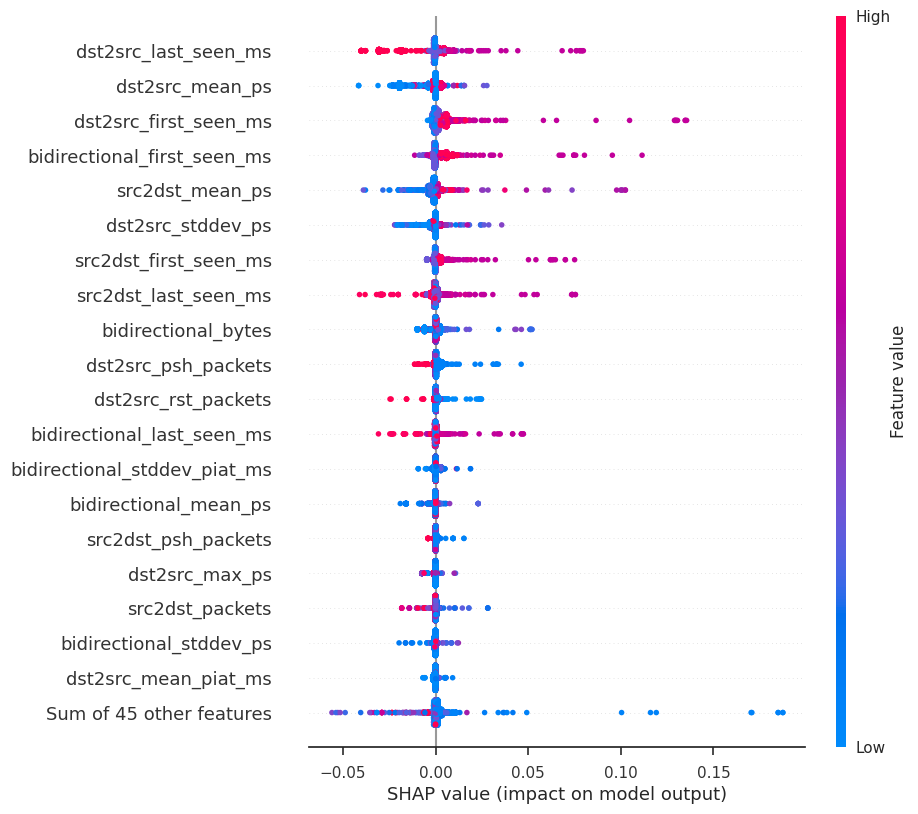

In [66]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## Web Attack - XSS shap

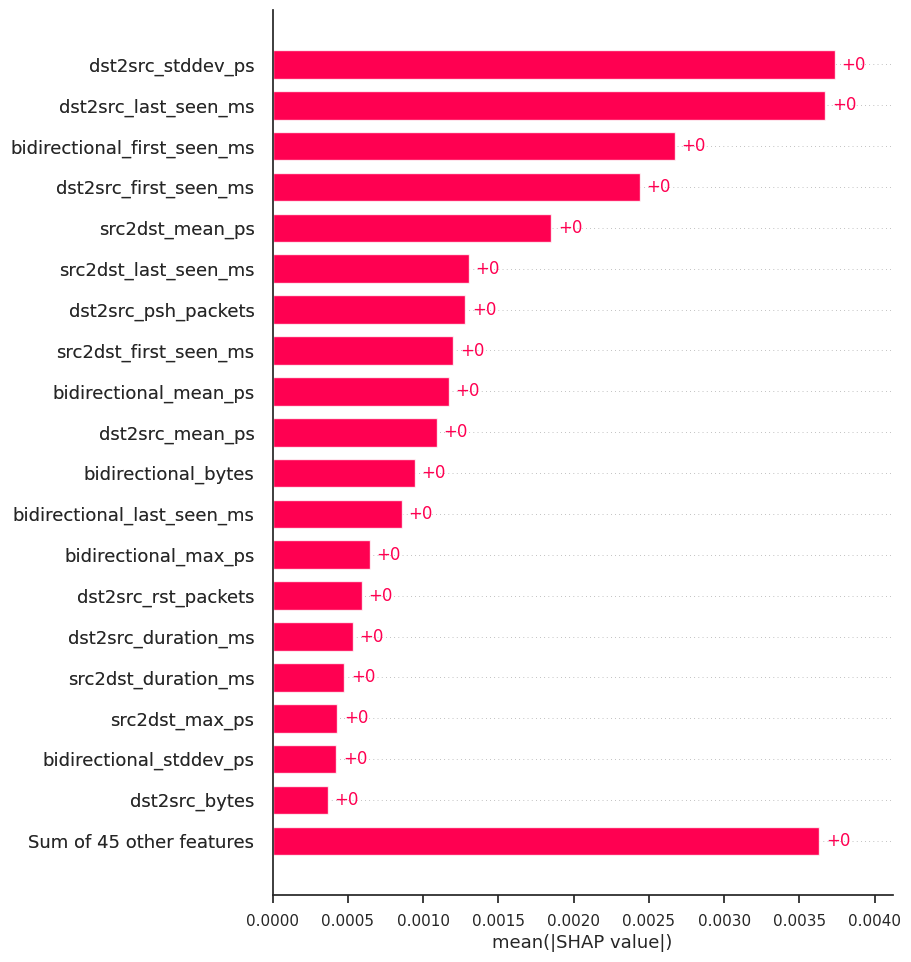

In [67]:
exp = Explanation(sv.values[:,:,14], 
                  sv.base_values[:,14], 
                  data=X_train, 
                  feature_names=X_res.columns)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

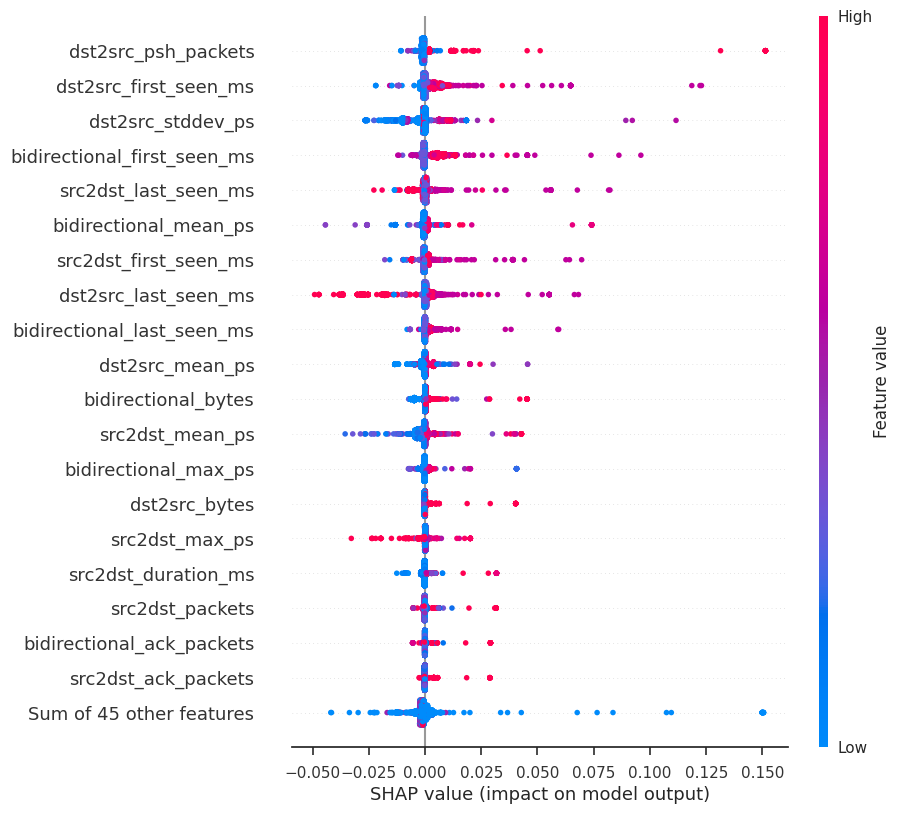

In [68]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

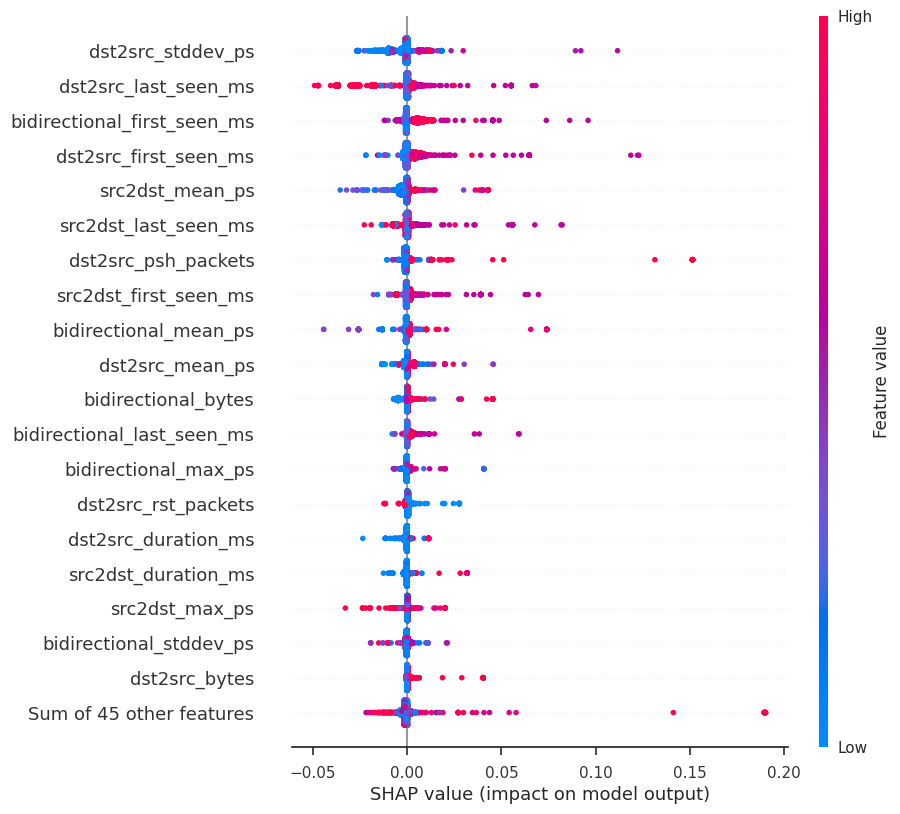

In [69]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)